<a href="https://colab.research.google.com/github/ndrep/bioinformatics/blob/main/Bioinformatic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount drive

from google.colab import drive

drive.mount("/drive/")

#Installing requirements

!pip install -q "cache_decorator[all]"==2.0.8 humanize scikit-learn
!pip install -q barplots plot_keras_history epigenomic_dataset>=1.1.7
!pip install -q ucsc_genomes_downloader>=1.1.22 keras_bed_sequence>=1.1.5
!pip install -q keras_mixed_sequence ray seaborn minepy boruta prince cmake
!pip install -q multicoretsne silence_tensorflow>=1.1.1
!pip install tsnecuda==3.0.0+cu110 -f https://tsnecuda.isx.ai/tsnecuda_stable.html --no-dependencies
!pip install -q faiss tbb
!pip install extra_keras_metrics
!pip install -U keras-tuner

#Import packages

In [1]:
from typing import Dict, List, Tuple, Optional
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LogNorm
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from epigenomic_dataset.utils import get_cell_lines
from typing import Tuple
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from extra_keras_metrics import get_complete_binary_metrics
from tsnecuda import TSNE
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence
from keras_tuner import BayesianOptimization, Hyperband
import keras_tuner as kt
import tensorflow.keras
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers.pooling import AveragePooling1D
import warnings
warnings.filterwarnings('ignore')

# Import Epigenomic Data

In [2]:
#modificare in base alla propria cell_line
cell_line='MCF-7'
#cell_line='K562'
#cell_line='A549'

In [3]:
from epigenomic_dataset import active_promoters_vs_inactive_promoters, active_enhancers_vs_inactive_enhancers

X_AP_vs_IP, y_AP_vs_IP= active_promoters_vs_inactive_promoters(cell_line=cell_line, binarize=True)
X_AE_vs_IE, y_AE_vs_IE=active_enhancers_vs_inactive_enhancers(cell_line=cell_line, binarize=True, min_active_tpm_value=0, max_inactive_tpm_value=0)

samples = {
    'promoter':X_AP_vs_IP,
    'enhancer':X_AE_vs_IE
}

labels = {
    'promoter':y_AP_vs_IP, 
    'enhancer':y_AE_vs_IE
}

In [4]:
samples['promoter']

chrom                              SNIP1  CREB1  NRF1  TAF1   ZFX  H2AFZ  \
chrom chromStart chromEnd  strand                                          
chr1  628964     629220    +        0.43   0.27  0.14  0.39  0.30   0.41   
      629013     629269    +        0.55   0.21  0.23  0.39  0.32   0.38   
      629642     629898    +        0.06   0.18  0.22  0.13  0.17   0.11   
      629847     630103    +        0.25   0.87  0.78  0.87  0.11   0.36   
      629905     630161    +        0.26   1.07  0.87  0.89  0.09   0.38   
...                                  ...    ...   ...   ...   ...    ...   
chrX  154441877  154442133 +        1.27   0.71  1.16  0.47  1.03   0.57   
      154584927  154585183 +        0.00   0.00  0.00  0.00  0.00   0.00   
chrY  1452882    1453138   -        0.00   0.00  0.00  0.00  0.00   0.00   
      2500959    2501215   -        0.00   0.00  0.00  0.00  0.00   0.00   
      14055973   14056229  +        0.00   0.00  0.00  0.00  0.00   0.00   

chrom                              NFRKB  ZBTB11  ZNF331  ZNF444  ...  ZNF687  \
chrom chromStart chromEnd  strand                                 ...           
chr1  628964     629220    +        0.24    0.00    0.68    0.43  ...    0.25   
      629013     629269    +        0.21    0.00    0.72    0.43  ...    0.22   
      629642     629898    +        0.00    0.11    0.00    0.08  ...    0.05   
      629847     630103    +        0.29    0.43    0.12    0.68  ...    0.15   
      629905     630161    +        0.43    0.30    0.21    0.80  ...    0.31   
...                                  ...     ...     ...     ...  ...     ...   
chrX  154441877  154442133 +        0.73    0.38    1.37    1.18  ...    0.84   
      154584927  154585183 +        0.00    0.00    0.00    0.00  ...    0.00   
chrY  1452882    1453138   -        0.00    0.00    0.00    0.00  ...    0.00   
      2500959    2501215   -        0.00    0.00    0.00    0.00  ...    0.00   
      14055973   14056229  +        0.00    0.00    0.00    0.00  ...    0.00   

chrom                               MYC  HES1  TARDBP  RFX5  SMARCA5  KLF4  \
chrom chromStart chromEnd  strand                                            
chr1  628964     629220    +       0.00  0.41    0.18  0.35     0.33  0.48   
      629013     629269    +       0.00  0.36    0.22  0.41     0.38  0.42   
      629642     629898    +       0.00  0.14    0.11  0.20     0.09  0.16   
      629847     630103    +       0.00  0.70    0.69  0.44     0.46  0.33   
      629905     630161    +       0.00  0.85    0.92  0.54     0.60  0.26   
...                                 ...   ...     ...   ...      ...   ...   
chrX  154441877  154442133 +       1.11  0.49    0.86  1.59     0.83  0.41   
      154584927  154585183 +       0.00  0.00    0.00  0.00     0.00  0.00   
chrY  1452882    1453138   -       0.00  0.00    0.00  0.00     0.00  0.00   
      2500959    2501215   -       0.00  0.00    0.00  0.00     0.00  0.00   
      14055973   14056229  +       0.00  0.00    0.00  0.00     0.00  0.00   

chrom                              SIN3A  E2F4  E4F1  
chrom chromStart chromEnd  strand                     
chr1  628964     629220    +        0.28  0.00  0.17  
      629013     629269    +        0.40  0.00  0.22  
      629642     629898    +        0.26  0.31  0.00  
      629847     630103    +        0.57  0.59  0.41  
      629905     630161    +        0.69  0.45  0.67  
...                                  ...   ...   ...  
chrX  154441877  154442133 +        0.77  0.47  0.70  
      154584927  154585183 +        0.00  0.00  0.00  
chrY  1452882    1453138   -        0.00  0.00  0.00  
      2500959    2501215   -        0.00  0.00  0.00  
      14055973   14056229  +        0.00  0.00  0.00  

[99881 rows x 117 columns]

# Data Cleaning

Evaluation of ratio between samples and features.

In [5]:
samples['promoter'].shape[0] / samples['promoter'].shape[1]

853.6837606837607

In [6]:
samples['enhancer'].shape[0] / samples['enhancer'].shape[1]

540.8974358974359

### Nan Imputation

X dataset have 182 nan values and it could be imputed with KNNImputer

In [7]:
samples['promoter'].isna().sum().sum()

182

In [8]:
labels['promoter'].isna().sum().sum()

0

In [9]:
samples['enhancer'].isna().sum().sum()

0

In [10]:
labels['enhancer'].isna().sum().sum()

0

In [11]:
from sklearn.impute import KNNImputer

def knn_imputation(df:pd.DataFrame, neighbours:int=5, weights:str='uniform')->pd.DataFrame:
    """Return provided dataframe with NaN imputed using knn.
    
    Parameters
    --------------------
    df:pd.DataFrame,
        The dataframe to impute.
    neighbours:int=5,
        The number of neighbours to consider.
    weights:str='uniform',
        Weight function used in prediction.
        
    Returns
    --------------------
    The dataframe with the NaN values imputed.
    """
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours, weights=weights).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [12]:
for region in samples.items():
  samples[region[0]] = knn_imputation(samples[region[0]])

In [13]:
for region in samples.items():
  print('Nan values in {} is {}'.format(region[0], samples[region[0]].isna().sum().sum()))

Nan values in promoter is 0
Nan values in enhancer is 0


### Drop Constant features

In [14]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

In [15]:
dropped_promoter = drop_constant_features(samples['promoter'])
dropped_enhancer = drop_constant_features(samples['enhancer'])

Check if some features hes been drop

In [16]:
dropped_promoter.shape != samples['promoter'].shape

False

In [17]:
dropped_enhancer.shape != samples['enhancer'].shape

False

In [18]:
samples['promoter'] = dropped_promoter
samples['enhancer'] = dropped_enhancer

### Data Scaling

In [19]:
from sklearn.preprocessing import RobustScaler

def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    """Return given dataframe scaled using robust z-scoring."""
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [20]:
samples['promoter'] = robust_zscoring(samples['promoter'])
samples['enhancer'] = robust_zscoring(samples['enhancer'])

### Class Balance

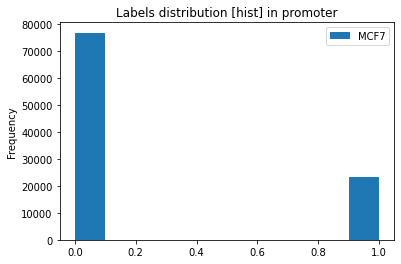

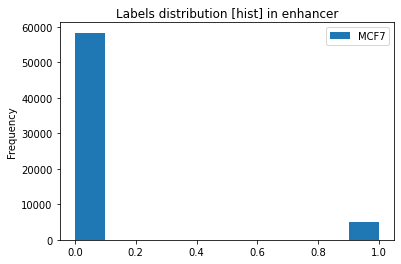

In [21]:
for (region, y) in labels.items():
  y.astype(int).plot.hist(title=f"Labels distribution [hist] in {region}")



In [22]:
label = 'MCF7'
for (region, y) in labels.items():
  print("active {} are {}% respect to total class".format(region, (y[label][y[label]==True].count()*100) / y[label][y[label]==False].count()))

active promoter are 30.10929175296677% respect to total class
active enhancer are 8.412992085517525% respect to total class


The classes, overall enhancer class, are very unbalance, but we don't will balance the classes like write in [Bayesian optimization improves tissue-specific prediction of active regulatory regions with deep neural networks](https://gvalentinib.ariel.ctu.unimi.it/v5/frm3/Download.aspx?toolName=contenuti&attachmentid=1037727) paper.

# Features Correlation & Features Selection

In [23]:
p_value_threshold = 0.01
correlation_threshold = 0.05

In [24]:
not_correlated_features = {'promoter':set(), 'enhancer':set()}

### Linear correlation with Pearson index


In [25]:
from scipy.stats import pearsonr

for (X,y) in zip(samples.items(), labels.items()):
  for feature in tqdm(X[1].columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    correlation, p_value = pearsonr(X[1][feature].values.flatten(), y[1].values.flatten())
    if p_value > p_value_threshold:
      print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output. p-value:{p_value} -- correlation:{correlation}")
      not_correlated_features[X[0]].add(feature)

Running Pearson test:   0%|                             | 0/117 [00:00<?, ?it/s]

In promoter the feature CSDE1 does not correlate in a statistically significant manner with the output. p-value:0.788266049766801 -- correlation:0.0008497867713343904


Running Pearson test:   0%|                             | 0/117 [00:00<?, ?it/s]

In enhancer the feature ARID3A does not correlate in a statistically significant manner with the output. p-value:0.17137943506880318 -- correlation:0.005437168115820575
In enhancer the feature CSDE1 does not correlate in a statistically significant manner with the output. p-value:0.17875231490014762 -- correlation:0.005345032112865498
In enhancer the feature LARP7 does not correlate in a statistically significant manner with the output. p-value:0.5775502141098324 -- correlation:0.0022140470542511143


### Linear correlation with Spearman index

In [26]:
from scipy.stats import spearmanr

for (X,y) in zip(samples.items(), labels.items()):
  for feature in tqdm(X[1].columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    correlation, p_value = spearmanr(X[1][feature].values.flatten(), y[1].values.flatten())
    if p_value > p_value_threshold:
      print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output. p-value:{p_value} -- correlation:{correlation}")
      not_correlated_features[X[0]].add(feature)

Running Pearson test:   0%|                             | 0/117 [00:00<?, ?it/s]

In promoter the feature SIX4 does not correlate in a statistically significant manner with the output. p-value:0.019820813495625794 -- correlation:0.007371609485307493


Running Pearson test:   0%|                             | 0/117 [00:00<?, ?it/s]

In enhancer the feature ARID3A does not correlate in a statistically significant manner with the output. p-value:0.07717396887110077 -- correlation:0.007025367102546445
In enhancer the feature CSDE1 does not correlate in a statistically significant manner with the output. p-value:0.7389310503081925 -- correlation:-0.0013248089003075486
In enhancer the feature CEBPG does not correlate in a statistically significant manner with the output. p-value:0.6321541439395504 -- correlation:0.001902911411879234
In enhancer the feature LARP7 does not correlate in a statistically significant manner with the output. p-value:0.1536808173366652 -- correlation:0.005671162886044895
In enhancer the feature E2F4 does not correlate in a statistically significant manner with the output. p-value:0.8129300883367411 -- correlation:-0.0009407201214266508


In [27]:
not_correlated_features

{'promoter': {'CSDE1', 'SIX4'},
 'enhancer': {'ARID3A', 'CEBPG', 'CSDE1', 'E2F4', 'LARP7'}}

### Not linear correlation with MIC

from minepy import MINE
import os
import json

if os.path.exists('/drive/MyDrive/bioinformatics/not_linear_correlation_json.json'):
  with open('/drive/MyDrive/bioinformatics/not_linear_correlation_json.json', 'r') as fp:
      not_linear_correlation = json.load(fp)
else:
  not_linear_correlation = {'promoter':set(), 'enhancer':set()}
  for (X,y) in zip(samples.items(), labels.items()):
    for items in not_correlated_features.items():
      for feature in tqdm(items[1], desc=f"Running MINE test", dynamic_ncols=True, leave=False):
          mine = MINE()
          mine.compute_score(X[1][feature].ravel(), y[1].values.ravel())
          score = mine.mic()
          if score < correlation_threshold:
              print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output.")
              not_linear_correlation[items[0]].add(feature)
  
  for region in not_linear_correlation.items():
    not_linear_correlation[region[0]] = list(region[1])

  json_object = json.dumps(not_linear_correlation, indent = 4)
  with open('/drive/MyDrive/not_linear_correlation_json.json', 'w') as writefile:
    writefile.write(json_object)

In [28]:
from minepy import MINE

not_linear_correlation = {'promoter':set(), 'enhancer':set()}
for (X,y) in zip(samples.items(), labels.items()):
    for items in not_correlated_features.items():
        for feature in tqdm(items[1], desc=f"Running MINE test", dynamic_ncols=True, leave=False):
            mine = MINE()
            mine.compute_score(X[1][feature].ravel(), y[1].values.ravel())
            score = mine.mic()
            if score < correlation_threshold:
                print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output.")
                not_linear_correlation[items[0]].add(feature)
                
for region in not_linear_correlation.items():
    not_linear_correlation[region[0]] = list(region[1])

Running MINE test:   0%|                                  | 0/2 [00:00<?, ?it/s]

In promoter the feature CSDE1 does not correlate in a statistically significant manner with the output.
In promoter the feature SIX4 does not correlate in a statistically significant manner with the output.


Running MINE test:   0%|                                  | 0/5 [00:00<?, ?it/s]

In promoter the feature E2F4 does not correlate in a statistically significant manner with the output.
In promoter the feature CEBPG does not correlate in a statistically significant manner with the output.
In promoter the feature CSDE1 does not correlate in a statistically significant manner with the output.
In promoter the feature LARP7 does not correlate in a statistically significant manner with the output.
In promoter the feature ARID3A does not correlate in a statistically significant manner with the output.


Running MINE test:   0%|                                  | 0/2 [00:00<?, ?it/s]

In enhancer the feature CSDE1 does not correlate in a statistically significant manner with the output.
In enhancer the feature SIX4 does not correlate in a statistically significant manner with the output.


Running MINE test:   0%|                                  | 0/5 [00:00<?, ?it/s]

In enhancer the feature E2F4 does not correlate in a statistically significant manner with the output.
In enhancer the feature CEBPG does not correlate in a statistically significant manner with the output.
In enhancer the feature CSDE1 does not correlate in a statistically significant manner with the output.
In enhancer the feature LARP7 does not correlate in a statistically significant manner with the output.
In enhancer the feature ARID3A does not correlate in a statistically significant manner with the output.


### Drop features not correlated with output

In [29]:
for region in samples.items():
  print(region[1].shape)

(99881, 117)
(63285, 117)


In [30]:
for region in samples.items():
  region[1].drop(list(not_linear_correlation[region[0]]), axis=1, inplace=True)

In [31]:
for region in samples.items():
  print(region[1].shape)

(99881, 115)
(63285, 112)


### Correlation with features

In [32]:
from scipy.stats import spearmanr

@Cache(
    cache_path="spearmanr/{_hash}.json",
    args_to_ignore=["X"]
)
def compute_spearmanr(
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str,
    cell_line: str,
    region: str
) -> Dict:
    """Returns Spearman correlation.
    
    Implementative details
    ------------------------------
    We may need to recompute this value across
    multiple re-runs of the jupyter notebook,
    so since it takes a bit of time to do so we cache it.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    cell_line: str,
        The cell line.
    region: str,
        The cis-regulatory region of interest.
    """
    correlation, p_value = spearmanr(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )

highly_correlated_future = {'promoter':[], 'enhancer':[]}

for X in tqdm(samples.items(), desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
  for feature_left in tqdm(X[1].columns, dynamic_ncols=True, leave=False):
      for feature_right in X[1].columns:
          if feature_left >= feature_right:
              continue
          pearson_result = compute_spearmanr(
              X[1],
              feature_left,
              feature_right,
              cell_line=cell_line,
              region="promoters"
          )
          if pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.99:
              correlation = pearson_result["correlation"]
              print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
              highly_correlated_future.append(feature_left)

              

Running Spearman test:   0%|                              | 0/2 [00:00<?, ?it/s]

  0%|                                                   | 0/115 [00:00<?, ?it/s]

  0%|                                                   | 0/112 [00:00<?, ?it/s]

In [33]:
for region in samples.items():
  print(region[1].shape)

(99881, 115)
(63285, 112)


In [34]:
for region in samples.items():
  region[1].drop(highly_correlated_future[region[0]], axis=1, inplace=True)

In [35]:
for region in samples.items():
  print(region[1].shape)

(99881, 115)
(63285, 112)


### Features selection with boruta

In [36]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from boruta import BorutaPy
from multiprocessing import cpu_count

def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    task_name: str,
    max_iter: int = 100,
    regression: bool = False,
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    regression: bool,
        Whether the task is a binary classification one (False) or a regression one (True).
    task_name: str,
        The name of the task.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """
    # According to the requested task we build either a random forest regressor
    # or a random forest classifier.
    if regression:
        model = RandomForestRegressor(n_jobs=cpu_count(), max_depth=5)
    else:
        model = RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5)
    
    # Create the Boruta model
    boruta_selector = BorutaPy(
        # Defining the model that Boruta should use.
        model,
        # We leave the number of estimators to be decided by Boruta
        n_estimators='auto',
        verbose=False,
        alpha=0.05, # p_value
        # In practice one would run at least 100-200 times,
        # until all tentative features are exausted.
        max_iter=max_iter, 
        random_state=42,
    )
    # Fit the Boruta model
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the kept features and discarded features
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    # Filter out the unused featured.
    return kept_features, discarded_features

# Import Sequence Data

In [37]:
from ucsc_genomes_downloader import Genome

#%cp -r /genomes /content/

genome = Genome("hg38")

Loading chromosomes for genome hg38:   0%|               | 0/25 [00:00<?, ?it/s]

In [38]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

In [39]:
sequence = {'promoter':pd.DataFrame(
                        np.array(BedSequence(
                            genome,
                            bed=to_bed(labels['promoter']),
                            batch_size=1
                        )).reshape(-1, 4*256),
                        index=labels['promoter'].index
                    )
            , 
            'enhancer': pd.DataFrame(
                        np.array(BedSequence(
                            genome,
                            bed=to_bed(labels['enhancer']),
                            batch_size=1
                        )).reshape(-1, 4*256),
                        index=labels['enhancer'].index
                    )
          }

In [40]:
sequence

{'promoter':                                    0     1     2     3     4     5     6     \
 chrom chromStart chromEnd  strand                                             
 chr1  628964     629220    +        0.0   0.0   0.0   1.0   0.0   0.0   1.0   
       629013     629269    +        1.0   0.0   0.0   0.0   0.0   1.0   0.0   
       629642     629898    +        0.0   0.0   1.0   0.0   0.0   0.0   0.0   
       629847     630103    +        0.0   0.0   1.0   0.0   0.0   0.0   0.0   
       629905     630161    +        0.0   1.0   0.0   0.0   1.0   0.0   0.0   
 ...                                 ...   ...   ...   ...   ...   ...   ...   
 chrX  154441877  154442133 +        0.0   0.0   1.0   0.0   0.0   0.0   0.0   
       154584927  154585183 +        0.0   1.0   0.0   0.0   1.0   0.0   0.0   
 chrY  1452882    1453138   -        0.0   0.0   0.0   1.0   0.0   1.0   0.0   
       2500959    2501215   -        0.0   1.0   0.0   0.0   0.0   0.0   1.0   
       14055973   14056229  

# Data visualization with t-SNE or PCA 

In [41]:
tasks = {
    "x":[
        *[
            val.values
            for val in samples.values()
        ]
    ],
    "y":[
        *[
            val.values.ravel()
            for val in labels.values()
        ]
    ],
    "titles":[
        "Epigenomes promoters",
        "Epigenomes enhancers"
    ]
}

tasks


xs = tasks["x"]
ys = tasks["y"]
titles = tasks["titles"]

assert len(xs) == len(ys) == len(titles)

for x, y in zip(xs, ys):
    assert x.shape[0] == y.shape[0]

In [42]:
tasks_seq = {
    "x":[
        *[
            val.values
            for val in sequence.values()
        ]
    ],
    "y":[
        *[
            val.values.ravel()
            for val in labels.values()
        ]
    ],
    "titles":[
        "Sequence promoters",
        "Sequence enhancers"
    ]
}

tasks_seq


xss = tasks_seq["x"]
yss = tasks_seq["y"]
titless = tasks_seq["titles"]

assert len(xss) == len(yss) == len(titless)

for x, y in zip(xss, yss):
    assert x.shape[0] == y.shape[0]

### PCA decomposition

In [43]:
from sklearn.decomposition import PCA

def pca(x:np.ndarray)->np.ndarray:
    return PCA(n_components=2, random_state=42).fit_transform(x)

Computing PCAs:   0%|          | 0/2 [00:00<?, ?it/s]

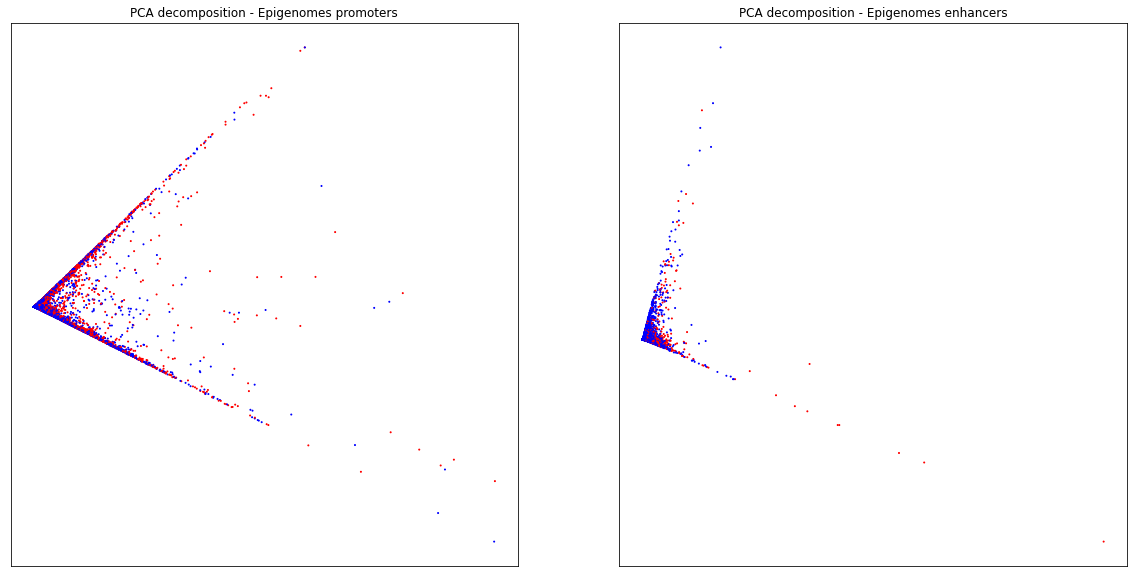

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xs, ys, titles, axes.flatten()), desc="Computing PCAs", total=len(xs)):
    axis.scatter(*pca(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"PCA decomposition - {title}")
plt.show()

Computing PCAs:   0%|          | 0/2 [00:00<?, ?it/s]

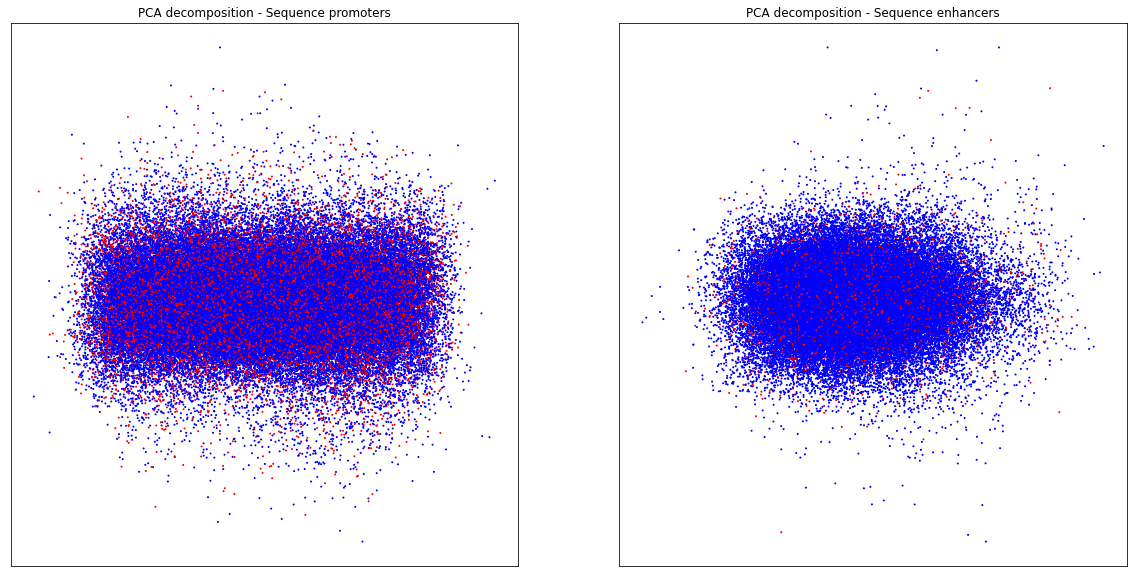

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xss, yss, titless, axes.flatten()), desc="Computing PCAs", total=len(xss)):
    axis.scatter(*pca(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"PCA decomposition - {title}")
plt.show()

### t-SNE decomposition

In [46]:
import gc
import tsnecuda
from tsnecuda import TSNE
import multiprocessing
from multiprocessing import Process, Queue

def tsne(X:np.ndarray)->np.ndarray:
    return TSNE(
            # Better performance may be achieved with cosine distance,
            # but currently TSNECUDA does not support other metrics.
            # Expecially for the sequence data, cosine distances may be foundamental
            # to get a semantically significant decomposition.
            perplexity= 30,
            n_iter = 1000,
            verbose=True,
        ).fit_transform(X)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xs, ys, titles, axes.flatten()), desc="Computing t-SNE", total=len(xs)):
    axis.scatter(*tsne(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"t-SNE decomposition - {title}")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xss, yss, titless, axes.flatten()), desc="Computing t-SNE", total=len(xss)):
    axis.scatter(*tsne(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"t-SNE decomposition - {title}")
plt.show()

# Classification Models

### FFNN model

In [47]:
class FFNNHyperModel(kt.HyperModel):
  
  def __init__(self, input_shape):
    self.input_shape = input_shape    

  def build(self, hp):
    
    hp1 = hp.Choice('hp1', [256, 128, 64])
    hp2 = hp.Choice('hp2', [128, 64, 32])
    hp3 = hp.Choice('hp3', [32, 16, 8])

    input_epigenomic_data = Input(shape=(self.input_shape,), name="epigenomic_data")
    hidden = Dense(hp1, activation="relu", name="dense_ffnn")(input_epigenomic_data)
    hidden = PReLU(name="prelu_ffnn")(hidden)
    hidden = BatchNormalization(name="norm_ffnn")(hidden)
    hidden = Dropout(rate=0.3, name="dropout_ffnn")(hidden)

    hidden = Dense(hp2, activation="relu", name="dense_1_ffnn")(hidden)
    hidden = PReLU(name="prelu_2_ffnn")(hidden)
    hidden = BatchNormalization(name="norm_2_ffnn")(hidden)
    hidden = Dropout(rate=0.3, name="droupout_1_ffnn")(hidden)

    hidden = Dense(hp3, activation="relu", name="dense_2_ffnn")(hidden)
    hidden = PReLU(name="prelu_3_ffnn")(hidden)
    hidden = BatchNormalization(name="norm_3_ffnn")(hidden)
    hidden = Dropout(rate=0.3, name="last_hidden_ffnn")(hidden)
    
    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid", name="output_ffnn")(last_hidden_ffnn)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="Bayesian_Optimization_FFNN"
    )

    ffnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    
    return ffnn


#### Baesyan Optimization Classification function

In [48]:
def baesyan_optimization_FFNN_classification(
    train_sequence: MixedSequence,
    test_sequence: MixedSequence,
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    
    tuner = BayesianOptimization(
      FFNNHyperModel(input_shape),
      objective='val_accuracy',
      max_trials=2,
      overwrite=True,
      project_name="FFNN_BO"
    )

    tuner.search(
      train_sequence,
      validation_data=test_sequence,
      epochs=30,
      verbose=False,
      callbacks=[
          EarlyStopping(
              "loss",
              min_delta=0.001,
              patience=2,
              mode="min"
          )
      ]
    )
    
    model = tuner.get_best_models()[0]
        
    return model, model.get_layer("epigenomic_data").output, model.get_layer("last_hidden_ffnn").output

#### Fixed Classification Model

In [49]:
def build_fixed_model_FFNN_classification(input_shape: int):

  input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
  hidden = Dense(256, activation="relu")(input_epigenomic_data)
  hidden = Dense(128, activation="relu")(hidden)
  hidden = PReLU()(hidden)
  hidden = BatchNormalization()(hidden)
  hidden = Dropout(rate=0.5)(hidden)

  hidden = Dense(64, activation="relu")(hidden)
  hidden = Dropout(rate=0.5)(hidden)
  
  hidden = Dense(32, activation="relu")(hidden)
  hidden = Dense(16, activation="relu")(hidden)
  hidden = PReLU()(hidden)
  hidden = BatchNormalization()(hidden)
  hidden = Dropout(rate=0.5)(hidden)

  last_hidden_ffnn = hidden
  output_ffnn = Dense(1, activation="sigmoid")(last_hidden_ffnn)

  ffnn = Model(
      inputs=input_epigenomic_data,
      outputs=output_ffnn,
      name="Fixed_FFNN"
  )
  
  ffnn.compile(
      optimizer="nadam",
      loss="binary_crossentropy",
      metrics=get_complete_binary_metrics()
  )

  return ffnn, input_epigenomic_data, last_hidden_ffnn


#### Get sequence

In [50]:
def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

### CNN model

Come strutturare una CNN?

- Convilution (Appliazione dei filtri per generale e feature maps
- Non linearity (ReLU)
- Pooling (serve per diminuire la dimensionalità del layer). La tecnica consiste nel prendere una vinestra (2x2) e spostarla su tutto il layer e di ogni finiestra prendo solo il valore massimo. 

#### Hypermodel

In [51]:
class CNNHyperModel(kt.HyperModel):
  
  def __init__(self, window_size):
    self.window_size = window_size    

  def build(self, hp):

    input_sequence_data = Input(shape=(self.window_size, 4), name="sequence_data")
    hidden = Conv1D(64, kernel_size=5, activation="relu")(input_sequence_data)
    hidden = BatchNormalization()(hidden)
    hidden = Conv1D(64, kernel_size=5, activation="relu")(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Conv1D(64, kernel_size=5, activation="relu")(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = MaxPool1D()(hidden)
    hidden = Conv1D(hp.Choice('units', [32, 64, 128]), kernel_size=hp.Choice('kernel_size', [5, 10]), activation="relu")(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Flatten()(hidden)
    hidden = Dense(hp.Choice('units1', [10, 32, 64]), activation="relu")(hidden)
    hidden = Dropout(0.3)(hidden)
    hidden = Dense(hp.Choice('units2', [10, 32, 64]), activation="relu")(hidden)
    hidden = Dropout(0.3, name="last_hidden")(hidden)
    
    last_hidden_cnn = hidden
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="Bayesian_Optimization_CNN"
    )

    cnn.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=2e-3),
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return cnn


#### Baesyan Optimization Classification function

In [52]:
def baesyan_optimization_CNN_classification(
    train_sequence: MixedSequence,
    test_sequence: MixedSequence,
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    
    tuner = BayesianOptimization(
      CNNHyperModel(input_shape),
      objective='val_accuracy',
      max_trials=2,
      overwrite=True,
      project_name="BO_CNN"
    )

    tuner.search(
      train_sequence,
        validation_data=test_sequence,
        epochs=10,
        verbose=False,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=0.001,
                patience=2,
                mode="min"
            ),
        ]
    )
    
    model = tuner.get_best_models()[0]
        
    return model, model.get_layer("sequence_data").output, model.get_layer("last_hidden").output 

#### Fixed Classification Model

In [53]:
from tensorflow.keras.layers import PReLU, MaxPooling1D, GlobalMaxPooling1D

def build_fixed_model_CNN_classification(input_shape: int):
  
    input_sequence_data = Input(shape=(input_shape, 4), name="sequence_data")
    hidden = Conv1D(16, kernel_size=3, activation="relu")(input_sequence_data)
    hidden = MaxPooling1D()(hidden)

    hidden = Conv1D(32, kernel_size=3, activation="relu")(hidden)
    hidden = MaxPooling1D()(hidden)

    hidden = Conv1D(64, kernel_size=3, activation="relu")(hidden)
    hidden = MaxPooling1D()(hidden)
    hidden = Dropout(0.5)(hidden)

    hidden = GlobalMaxPooling1D()(hidden)

    hidden = Dense(128, activation="relu")(hidden)
    hidden = Dropout(0.5)(hidden)

    last_hidden_cnn = hidden
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="Fixed_CNN"
    )

    cnn.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=2e-3),
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return cnn, input_sequence_data, last_hidden_cnn

#### Get sequence

In [54]:
def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 576
) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

### MMNN Model

#### Classification function

In [55]:
def MMNN_classification(
    train_sequence_ffnn: MixedSequence = None,
    test_sequence_ffnn: MixedSequence = None,
    train_sequence_cnn: MixedSequence = None,
    test_sequence_cnn: MixedSequence = None,
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )

    if input_shape is not None:
        ffnn_model, input_epigenomic_data, last_hidden_ffnn = baesyan_optimization_FFNN_classification(train_sequence=train_sequence_ffnn, test_sequence=test_sequence_ffnn, input_shape=input_shape)
        
    if window_size is not None:
        cnn_model, input_sequence_data, last_hidden_cnn = baesyan_optimization_CNN_classification(train_sequence=train_sequence_cnn, test_sequence=test_sequence_cnn, input_shape=window_size)
    
    concatenation_layer = Concatenate()([last_hidden_ffnn,last_hidden_cnn])

    last_hidden_mmnn = Dense(10, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="BoostedMMNN" if input_shape is None else "MMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return mmnn

#### Fixed Calssification Model

In [56]:
def fixed_MMNN_classification(
  input_shape: Optional[int] = None,
  window_size: Optional[int] = None,
  input_epigenomic_data: Optional[Layer] = None,
  input_sequence_data: Optional[Layer] = None,
  last_hidden_ffnn: Optional[Layer] = None,
  last_hidden_cnn: Optional[Layer] = None
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )

    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_fixed_model_FFNN_classification(input_shape=input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_fixed_model_CNN_classification(input_shape=window_size)
    
    concatenation_layer = Concatenate()([last_hidden_ffnn,last_hidden_cnn])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="Fixed_MMNN" if input_shape is None else "Bayesian_Optimization_MMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return mmnn

#### Get sequence

In [57]:
def get_mmnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

### Traning and Evaluation

#### Train model

In [58]:
from tensorflow.keras.callbacks import EarlyStopping

'''@Cache(
    cache_path=[
        "model_histories/{cell_line}/{task}/{model_name}/history_{_hash}.csv.xz",
        "model_performance/{cell_line}/{task}/{model_name}/performance_{_hash}.csv.xz",
    ],
    args_to_ignore=[
        "model", "training_sequence", "test_sequence"
    ]
)'''
def train_model(
    model: Model,
    model_name: str,
    task: str,
    cell_line: str,
    train_sequence: MixedSequence,
    test_sequence: MixedSequence,
    holdout_number: int,
    use_feature_selection: bool
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Returns training history and model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    training_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=100,
        verbose=False,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=0.001,
                patience=2,
                mode="min"
            ),
        ]
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    train_evaluation["use_feature_selection"] = use_feature_selection
    test_evaluation["use_feature_selection"] = use_feature_selection

    
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
        evaluation["use_feature_selection"] = use_feature_selection
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

#### Holdouts Creation

In [59]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

# but normally at least 10 are executed
number_of_splits = 2

holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

regression_holdouts_generator = ShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

#### Models Evaluation

In [60]:
from tqdm.auto import tqdm
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from epigenomic_dataset.utils import normalize_epigenomic_data

# Create a list to store all the computed performance
all_binary_classification_performance = []

training_histories = {}

# For each task
for task in tqdm(((samples['promoter'],labels['promoter'], 'Promoter'),(samples['enhancer'],labels['enhancer'], 'Enhancer')), desc="Tasks"):

    # We get the task data with binarized labels
    X, y, task_name = task
    training_histories[task_name] = []

    bed = to_bed(X)

    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=number_of_splits,
        leave=False,
        desc="Computing holdouts"
    ):
            
        for use_feature_selection in tqdm((True, False), desc="Use Feature Selection"):
            
            number_of_features = X.shape[1]
            # Get the training and test data
            train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
            train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
            train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
            
            if use_feature_selection:
                kept_features, discarded_features = execute_boruta_feature_selection(
                    train_X,
                    train_y.values.ravel(),
                    holdout_number,
                    task_name
                )
                # We filter the DataFrames columns using the features that
                # Boruta has decided we should keep
                train_X = train_X[kept_features]
                test_X = test_X[kept_features]
                
                number_of_features = train_X.shape[1]
                
            # Flatten the output values
            train_y = train_y.values.flatten()
            test_y = test_y.values.flatten()

            train_sequence_ffnn = get_ffnn_sequence(train_X.values, train_y)
            test_sequence_ffnn = get_ffnn_sequence(test_X.values, test_y)

            train_sequence_cnn = get_cnn_sequence(genome, train_bed, train_y)
            test_sequence_cnn = get_cnn_sequence(genome, test_bed, test_y)

            train_sequence_mmnn = get_mmnn_sequence(genome, train_bed, train_X.values, train_y)
            test_sequence_mmnn = get_mmnn_sequence(genome, test_bed, test_X.values, test_y)

            bffnn, input_epigenomic_data_mmnn, last_hidden_ffnn = baesyan_optimization_FFNN_classification(train_sequence_ffnn, test_sequence_ffnn, number_of_features)
            bcnn, input_sequence_data_mmnn, last_hidden_cnn = baesyan_optimization_CNN_classification(train_sequence_cnn, test_sequence_cnn, 256)
            
            ffnn, input_epigenomic_data, _ = build_fixed_model_FFNN_classification(number_of_features)
            cnn, input_sequence_data, _ = build_fixed_model_CNN_classification(256)
            
            mmnn1 = fixed_MMNN_classification(
                    input_epigenomic_data=input_epigenomic_data_mmnn, 
                    input_sequence_data=input_sequence_data_mmnn,
                    last_hidden_ffnn=last_hidden_ffnn,
                    last_hidden_cnn=last_hidden_cnn
                    )
            mmnn2 = fixed_MMNN_classification(input_shape=number_of_features, window_size=256)

            for model, train_sequence, test_sequence in tqdm(
                (    
                    (bffnn, train_sequence_ffnn, test_sequence_ffnn),
                    (bcnn, train_sequence_cnn, test_sequence_cnn),
                    (ffnn, train_sequence_ffnn, test_sequence_ffnn),
                    (cnn, train_sequence_cnn, test_sequence_cnn),
                    (mmnn1, train_sequence_mmnn, test_sequence_mmnn),
                    (mmnn2, train_sequence_mmnn, test_sequence_mmnn),
                ),
                desc="Training models",
                leave=False
            ):


                # We compute the model performance
                history, performance = train_model(
                    model,
                    model.name,
                    task_name,
                    cell_line,
                    train_sequence,
                    test_sequence,
                    holdout_number,
                    use_feature_selection
                )
                training_histories[task_name].append(history)
                all_binary_classification_performance.append(performance)
                
 
# We convert the computed performance list into a DataFrame
all_binary_classification_performance = pd.concat(all_binary_classification_performance)
all_binary_classification_performance = all_binary_classification_performance.reset_index()
all_binary_classification_performance = all_binary_classification_performance.drop(['index'], axis=1)

Tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

Use Feature Selection:   0%|          | 0/2 [00:00<?, ?it/s]

2022-01-30 12:26:14.451262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 12:26:14.581742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 12:26:14.582131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 12:26:14.583275: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

INFO:tensorflow:Oracle triggered exit


2022-01-30 12:28:40.926203: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2022-01-30 12:28:41.329800: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0298s vs `on_train_batch_end` time: 0.0419s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0305s vs `on_train_batch_end` time: 0.0435s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

Use Feature Selection:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0302s vs `on_train_batch_end` time: 0.0427s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

Use Feature Selection:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0355s vs `on_train_batch_end` time: 0.0381s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

Use Feature Selection:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0378s vs `on_train_batch_end` time: 0.0425s). Check your callbacks.
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0330s vs `on_train_batch_end` time: 0.0339s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

#### Graphic results visualization

In [61]:
all_binary_classification_performance

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,informedness,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR,run_type,use_feature_selection,model_name,task,holdout_number
0,0.320884,0.845402,0.676167,0.662656,0.903819,0.695457,0.669343,0.786262,0.896357,0.323833,...,0.669377,0.564550,6.524021,0.361277,3.678627,train,True,Bayesian_Optimization_FFNN,Promoter,0
1,0.337607,0.833959,0.664287,0.635029,0.890876,0.655277,0.649329,0.774667,0.885046,0.335713,...,0.649493,0.532526,5.778730,0.379317,3.437871,test,True,Bayesian_Optimization_FFNN,Promoter,0
2,0.125553,0.942706,0.982748,0.810129,0.988195,0.961590,0.888129,0.956699,0.930650,0.017252,...,0.892274,0.804578,14.170801,0.018537,22.094191,train,True,Bayesian_Optimization_CNN,Promoter,0
3,1.264142,0.735546,0.551590,0.442708,0.730224,0.447144,0.491188,0.671262,0.790934,0.448410,...,0.494159,0.296897,2.638351,0.566937,2.041935,test,True,Bayesian_Optimization_CNN,Promoter,0
4,0.309370,0.838306,0.435725,0.764204,0.918278,0.737808,0.555004,0.697623,0.959520,0.564274,...,0.577047,0.613773,10.763935,0.588080,2.307127,train,True,Fixed_FFNN,Promoter,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.287302,0.922414,0.000000,0.000000,0.582574,0.126895,0.000000,0.500000,1.000000,1.000000,...,0.000000,-0.077586,0.000000,1.000000,1.000000,test,False,Fixed_CNN,Enhancer,1
92,0.002474,0.999526,0.994401,0.999488,0.999998,0.999971,0.996938,0.997179,0.999957,0.005599,...,0.996941,0.999017,23164.667969,0.005600,353.464355,train,False,Fixed_MMNN,Enhancer,1
93,1.138776,0.912381,0.045825,0.207373,0.546929,0.105648,0.075063,0.515546,0.985268,0.954175,...,0.097483,0.132052,3.110474,0.968442,1.064180,test,False,Fixed_MMNN,Enhancer,1
94,0.170235,0.930137,0.108170,0.927948,0.922870,0.631992,0.193754,0.553732,0.999293,0.891830,...,0.316822,0.858105,153.052032,0.892461,1.240804,train,False,Bayesian_Optimization_MMNN,Enhancer,1


In [62]:
all_performance = all_binary_classification_performance.copy()
all_performance["use_feature_selection"] = [
    "Feature Selection" if use_selection else "No Feature Selection"
    for use_selection in all_performance["use_feature_selection"]
]
all_performance = all_performance.drop(columns=["holdout_number"])

In [63]:
all_performance

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,fowlkes_mallows_index,informedness,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR,run_type,use_feature_selection,model_name,task
0,0.320884,0.845402,0.676167,0.662656,0.903819,0.695457,0.669343,0.786262,0.896357,0.323833,...,0.786262,0.669377,0.564550,6.524021,0.361277,3.678627,train,Feature Selection,Bayesian_Optimization_FFNN,Promoter
1,0.337607,0.833959,0.664287,0.635029,0.890876,0.655277,0.649329,0.774667,0.885046,0.335713,...,0.774667,0.649493,0.532526,5.778730,0.379317,3.437871,test,Feature Selection,Bayesian_Optimization_FFNN,Promoter
2,0.125553,0.942706,0.982748,0.810129,0.988195,0.961590,0.888129,0.956699,0.930650,0.017252,...,0.956699,0.892274,0.804578,14.170801,0.018537,22.094191,train,Feature Selection,Bayesian_Optimization_CNN,Promoter
3,1.264142,0.735546,0.551590,0.442708,0.730224,0.447144,0.491188,0.671262,0.790934,0.448410,...,0.671262,0.494159,0.296897,2.638351,0.566937,2.041935,test,Feature Selection,Bayesian_Optimization_CNN,Promoter
4,0.309370,0.838306,0.435725,0.764204,0.918278,0.737808,0.555004,0.697623,0.959520,0.564274,...,0.697623,0.577047,0.613773,10.763935,0.588080,2.307127,train,Feature Selection,Fixed_FFNN,Promoter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.287302,0.922414,0.000000,0.000000,0.582574,0.126895,0.000000,0.500000,1.000000,1.000000,...,0.500000,0.000000,-0.077586,0.000000,1.000000,1.000000,test,No Feature Selection,Fixed_CNN,Enhancer
92,0.002474,0.999526,0.994401,0.999488,0.999998,0.999971,0.996938,0.997179,0.999957,0.005599,...,0.997179,0.996941,0.999017,23164.667969,0.005600,353.464355,train,No Feature Selection,Fixed_MMNN,Enhancer
93,1.138776,0.912381,0.045825,0.207373,0.546929,0.105648,0.075063,0.515546,0.985268,0.954175,...,0.515546,0.097483,0.132052,3.110474,0.968442,1.064180,test,No Feature Selection,Fixed_MMNN,Enhancer
94,0.170235,0.930137,0.108170,0.927948,0.922870,0.631992,0.193754,0.553732,0.999293,0.891830,...,0.553732,0.316822,0.858105,153.052032,0.892461,1.240804,train,No Feature Selection,Bayesian_Optimization_MMNN,Enhancer


In [64]:
from barplots import barplots

def result(
    df: pd.DataFrame,
    value: str
):
    data = df.loc[df['task'] == value]
    barplots(
    df[["AUPRC", "AUROC", "accuracy","model_name", "use_feature_selection", "run_type"]],
    groupby=["model_name", "use_feature_selection", "run_type"],
    orientation="horizontal",
    height=8
)

Rendering barplots:   0%|                                 | 0/3 [00:00<?, ?it/s]

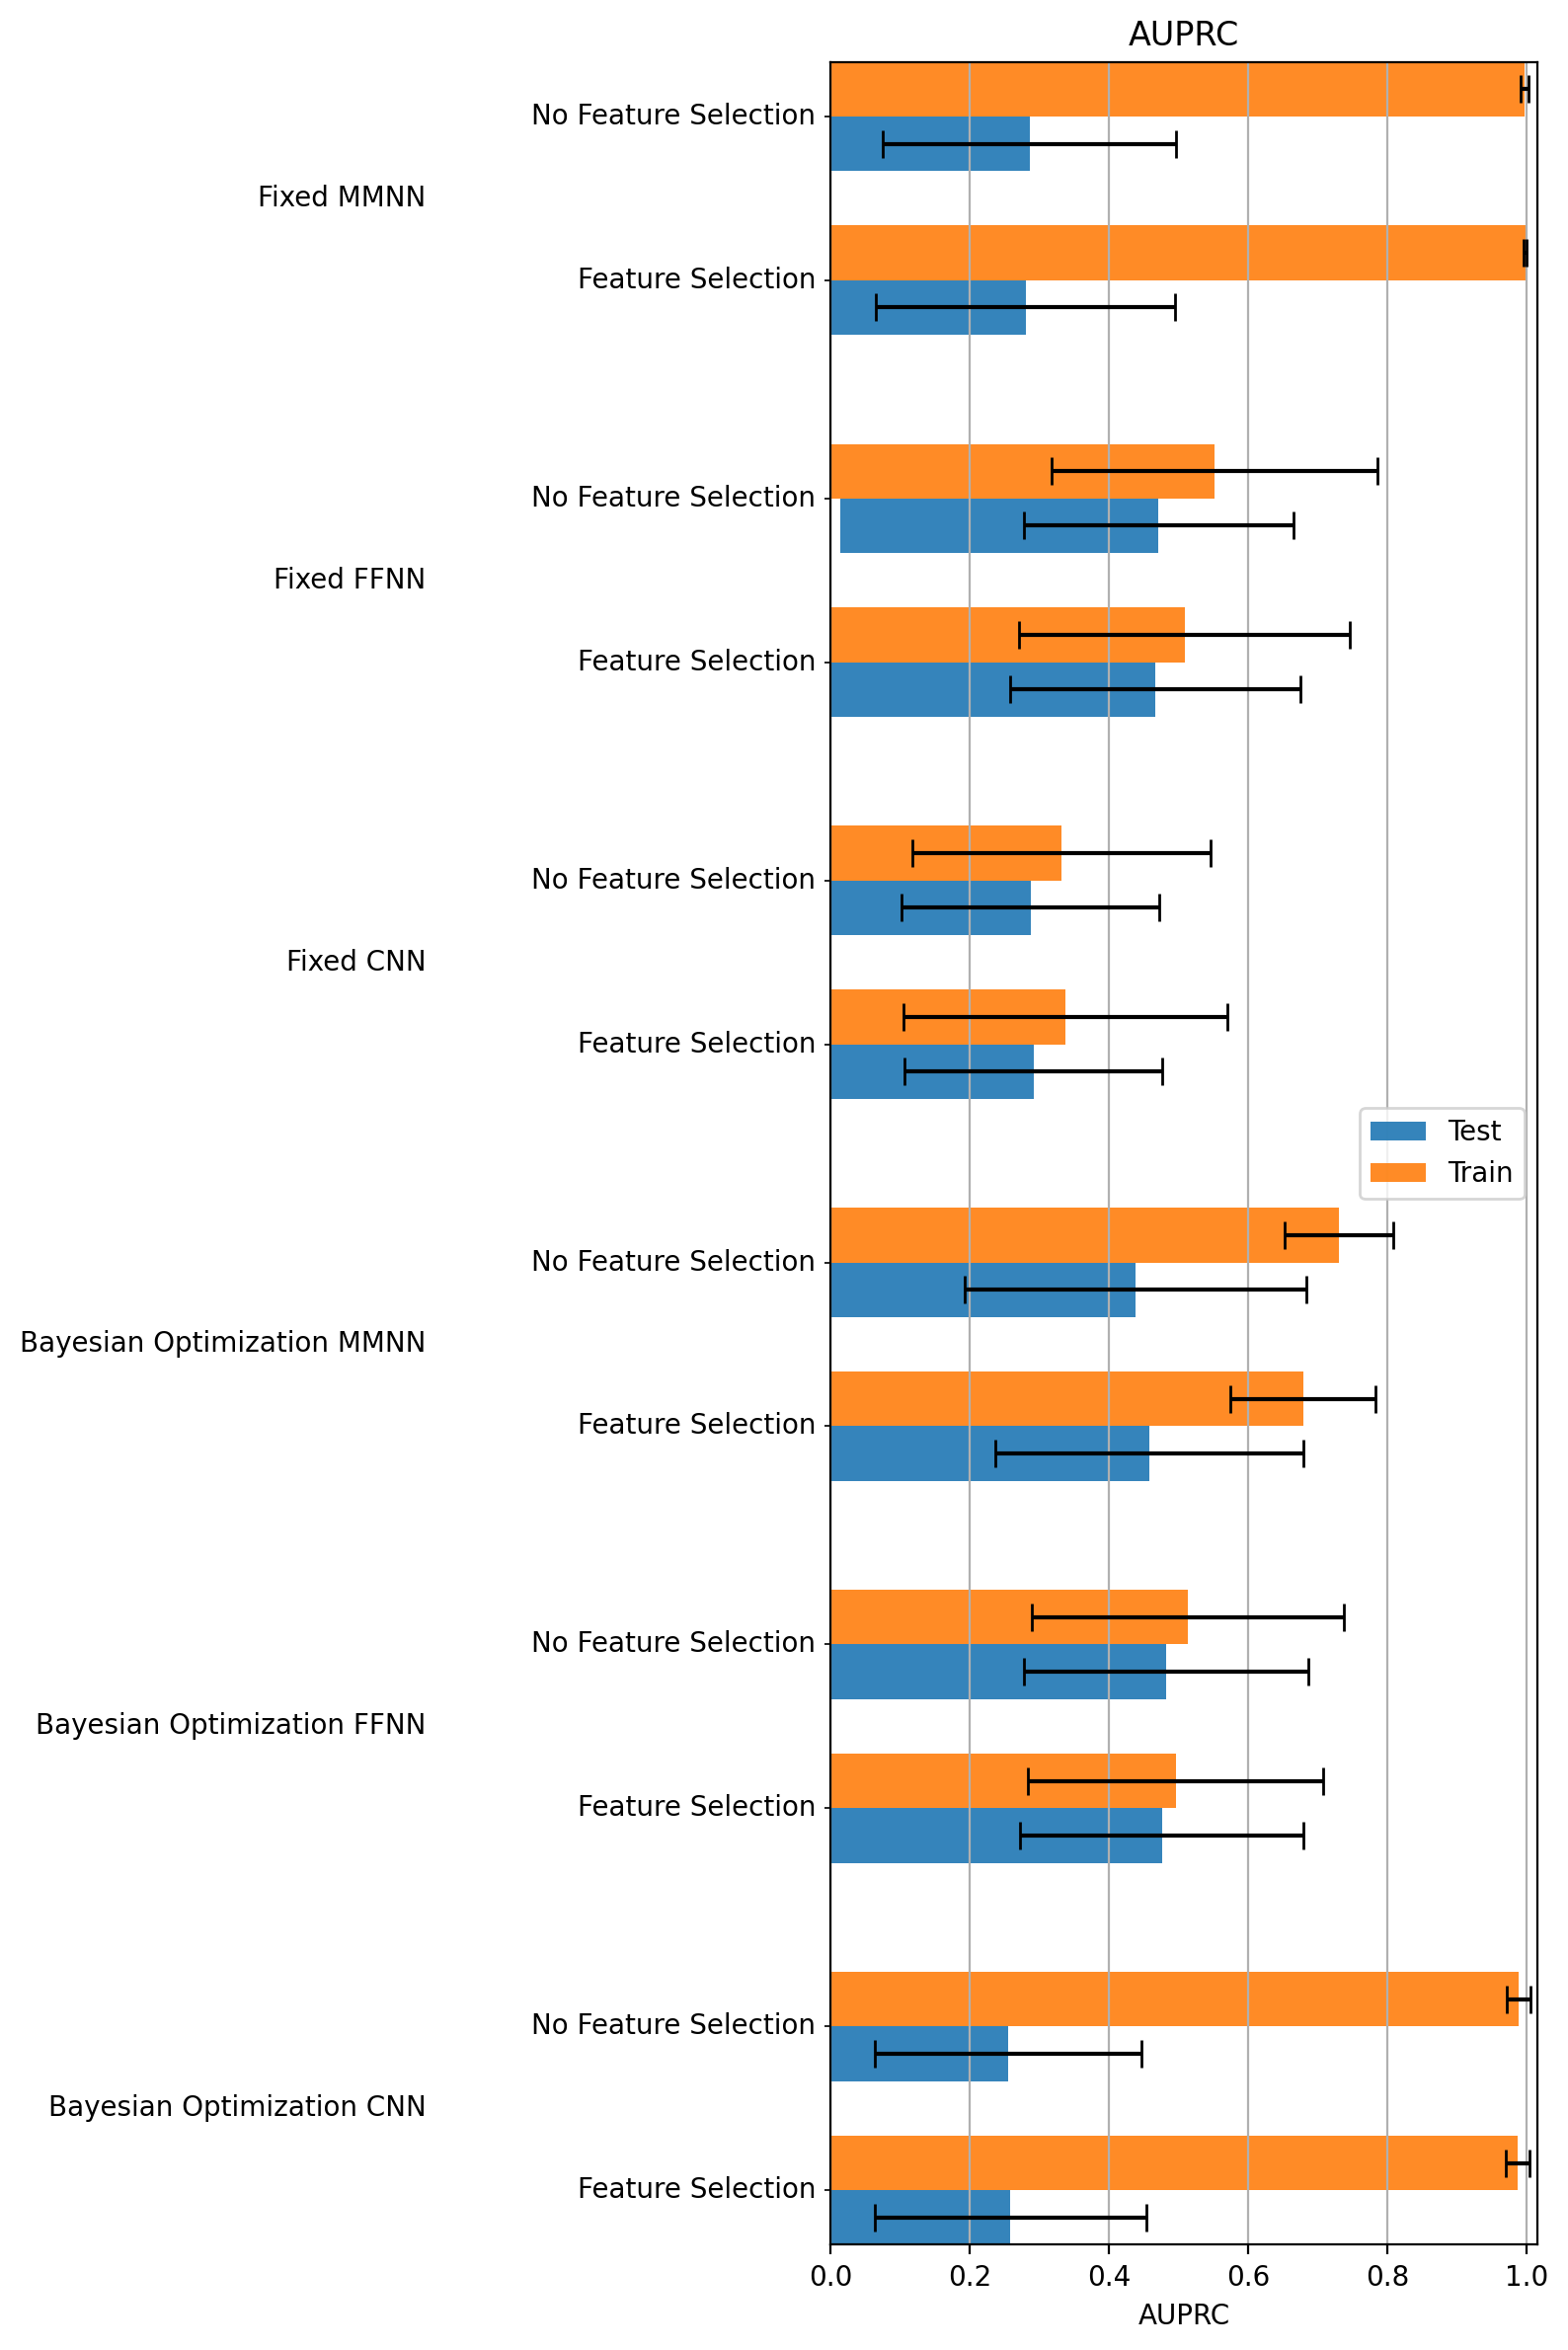

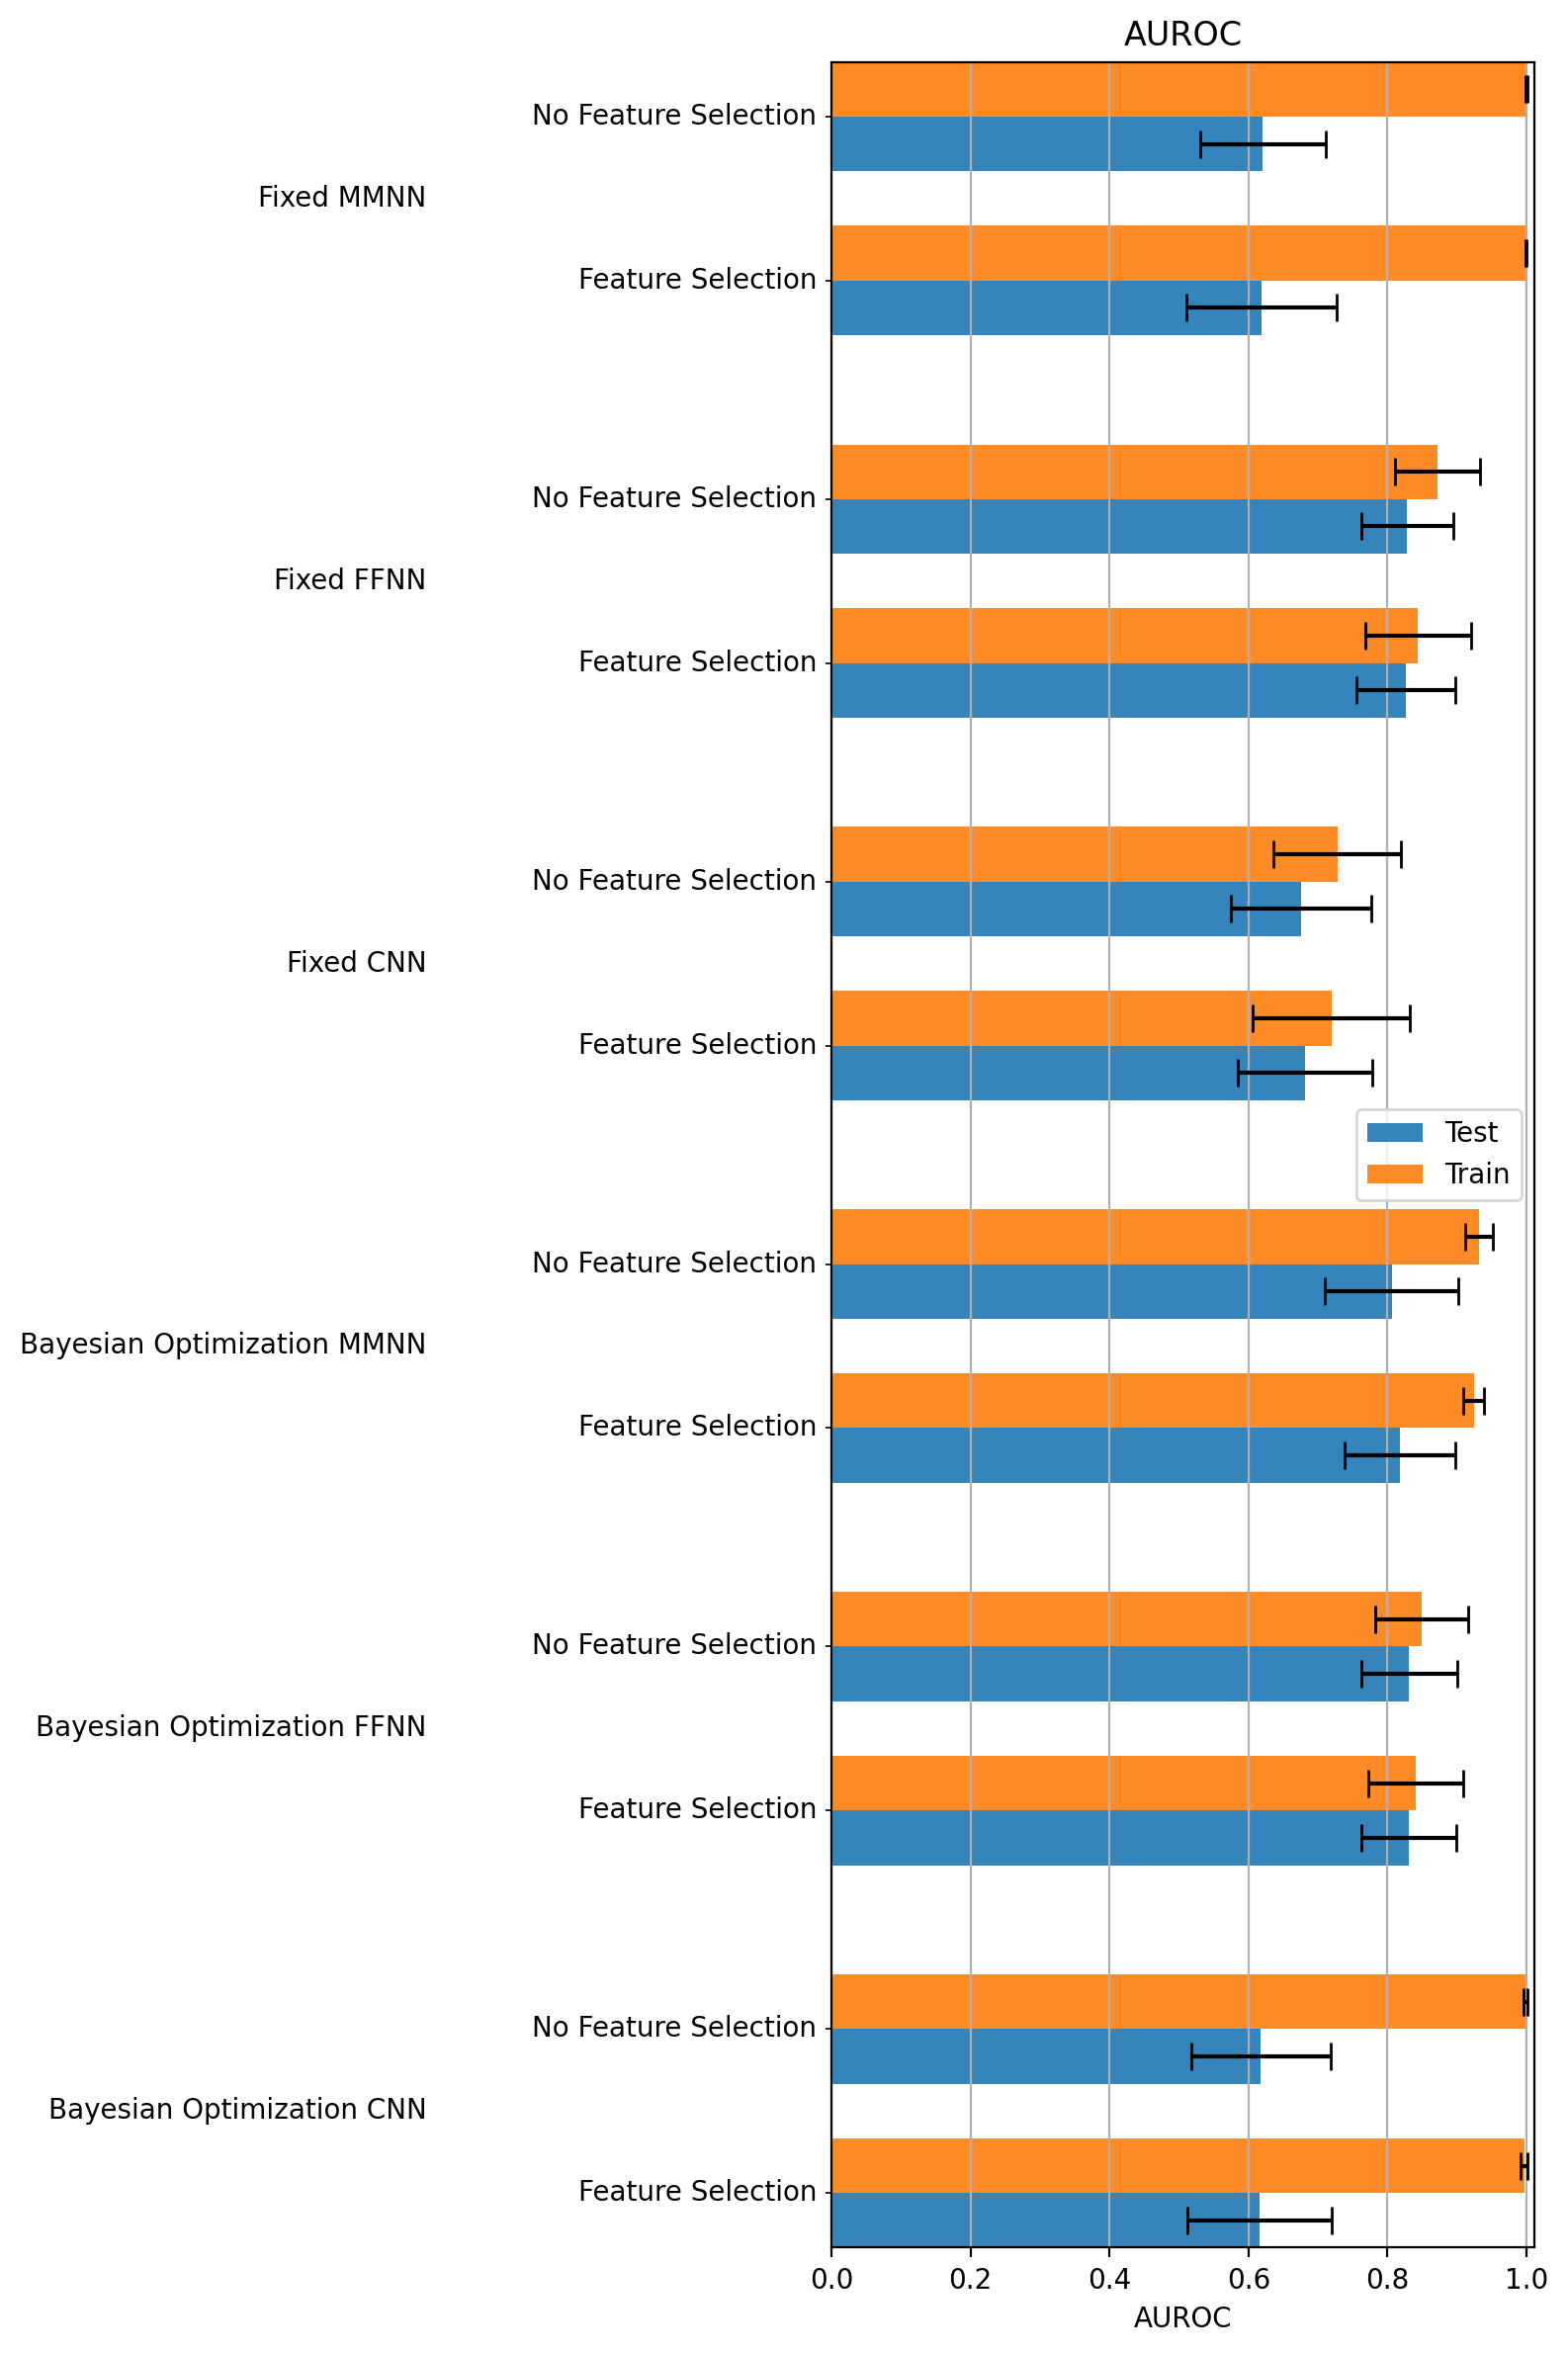

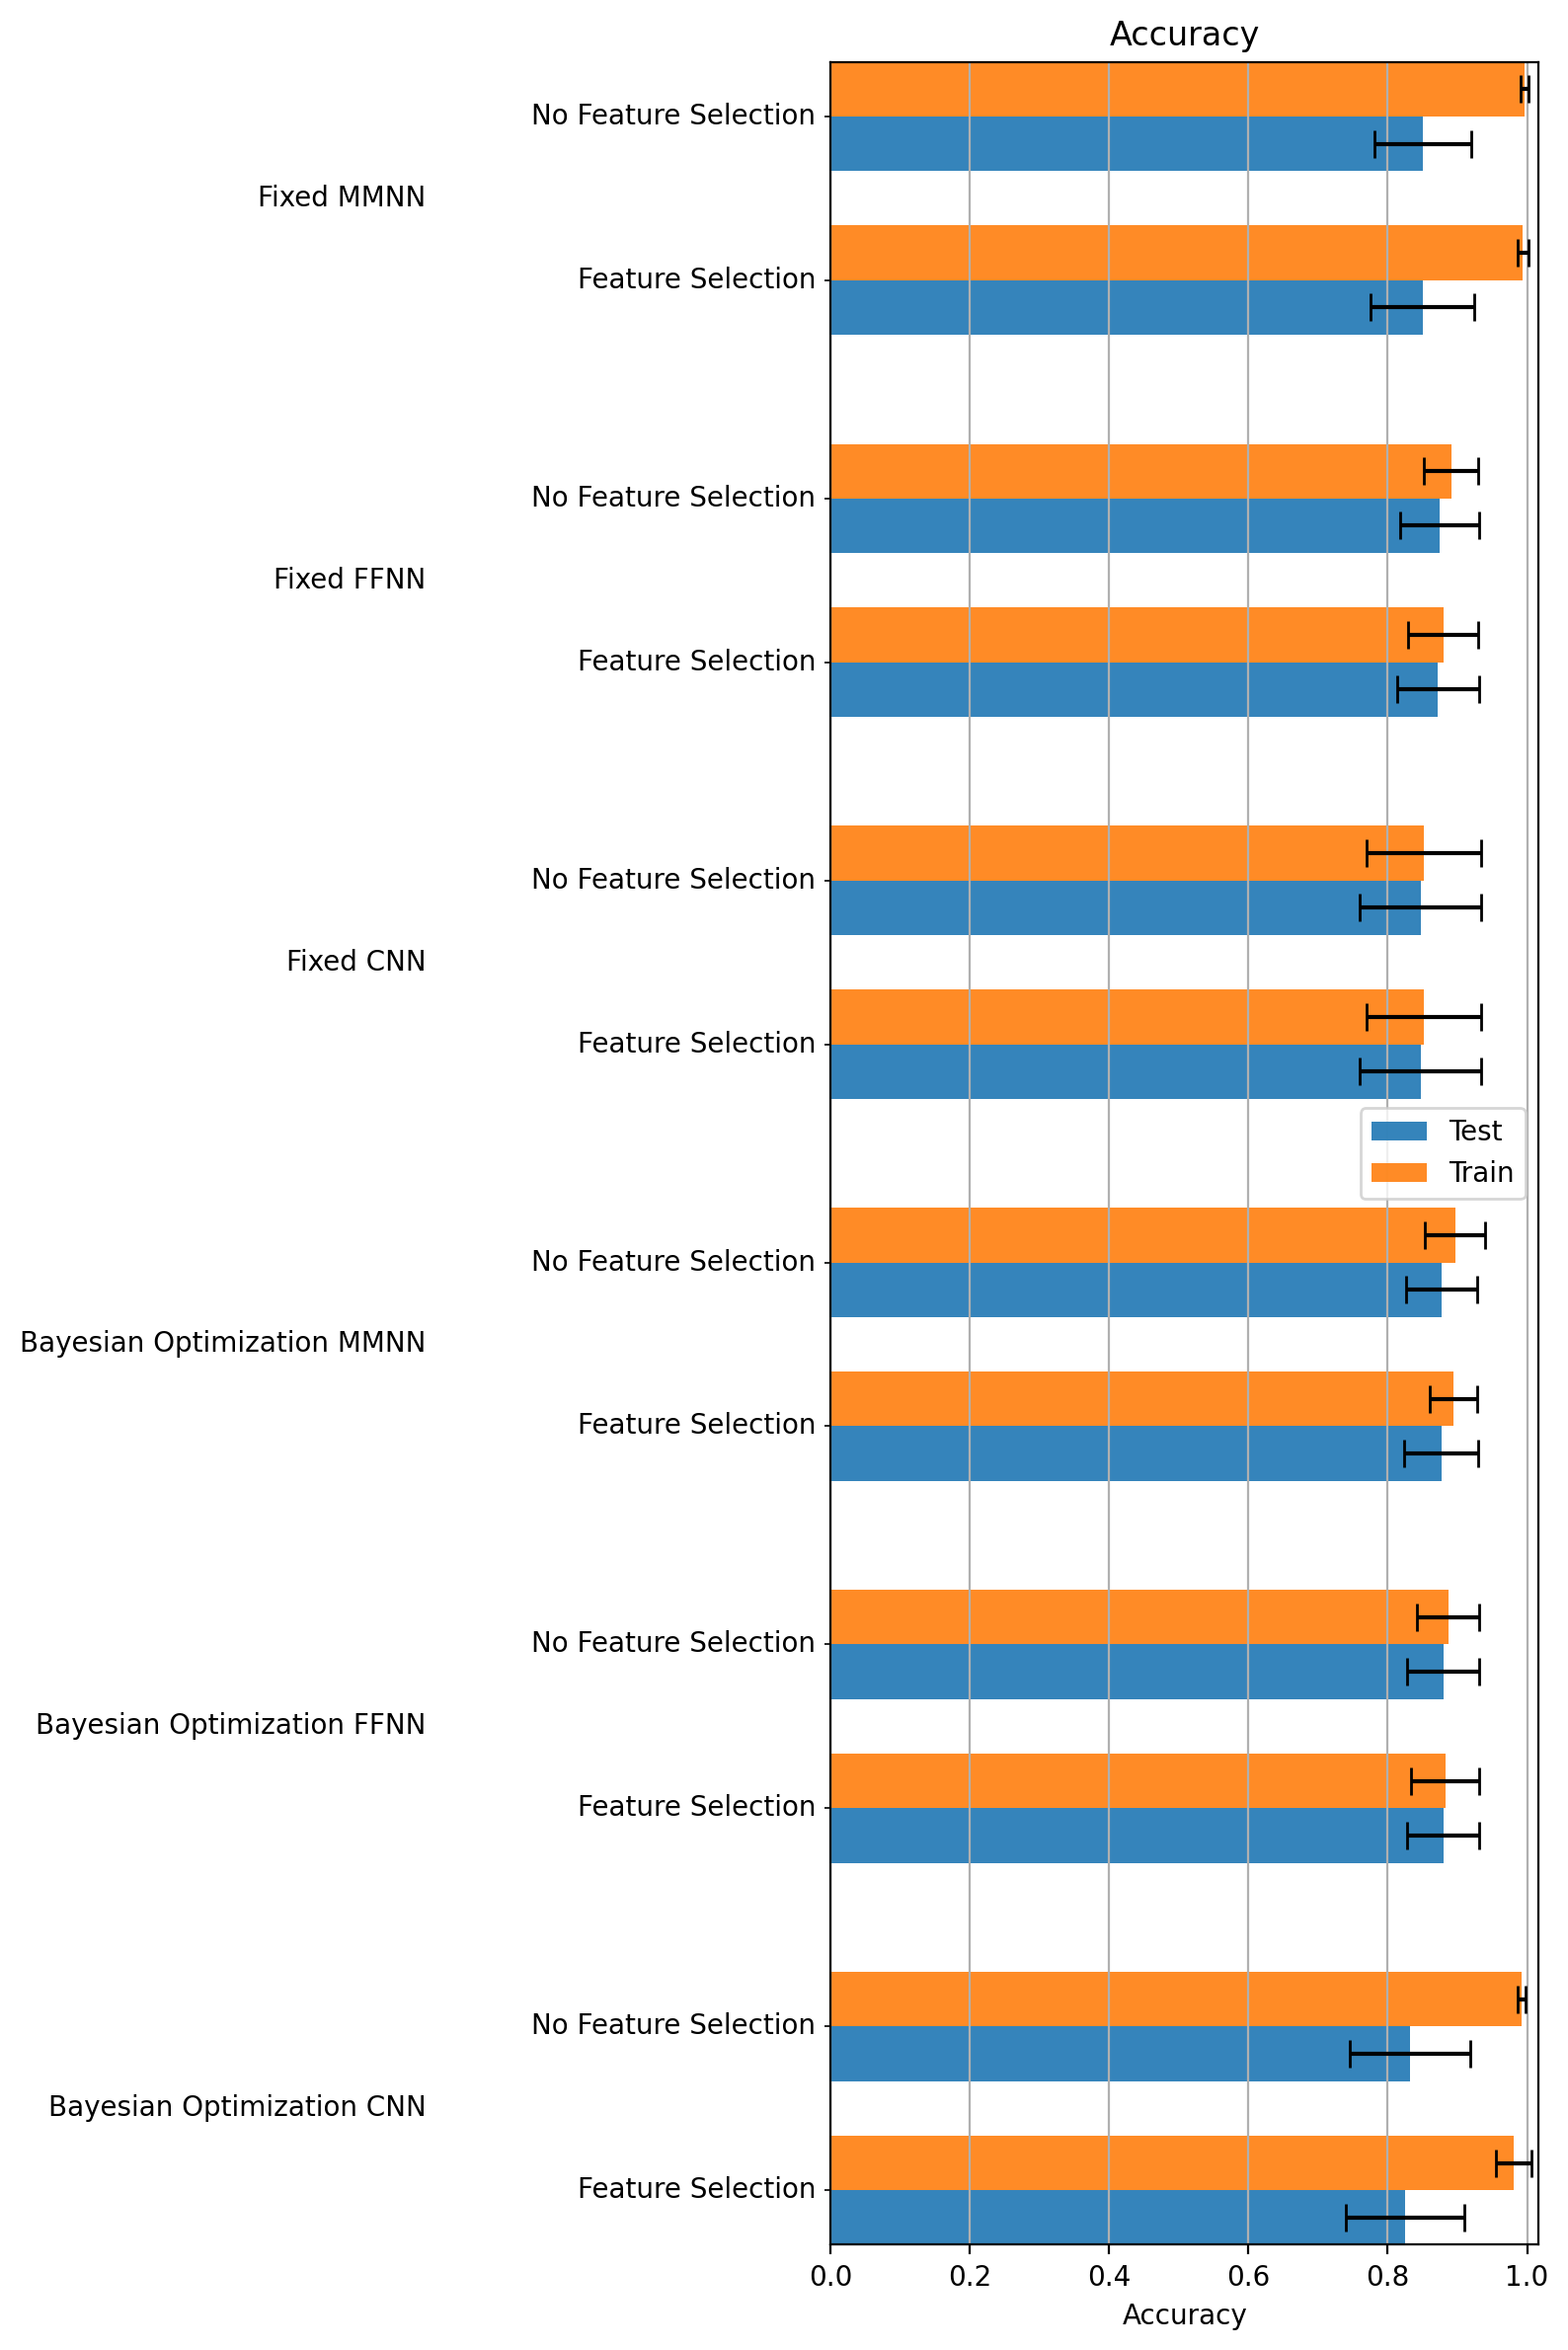

In [65]:
result(all_performance, "Promoter")

Rendering barplots:   0%|                                 | 0/3 [00:00<?, ?it/s]

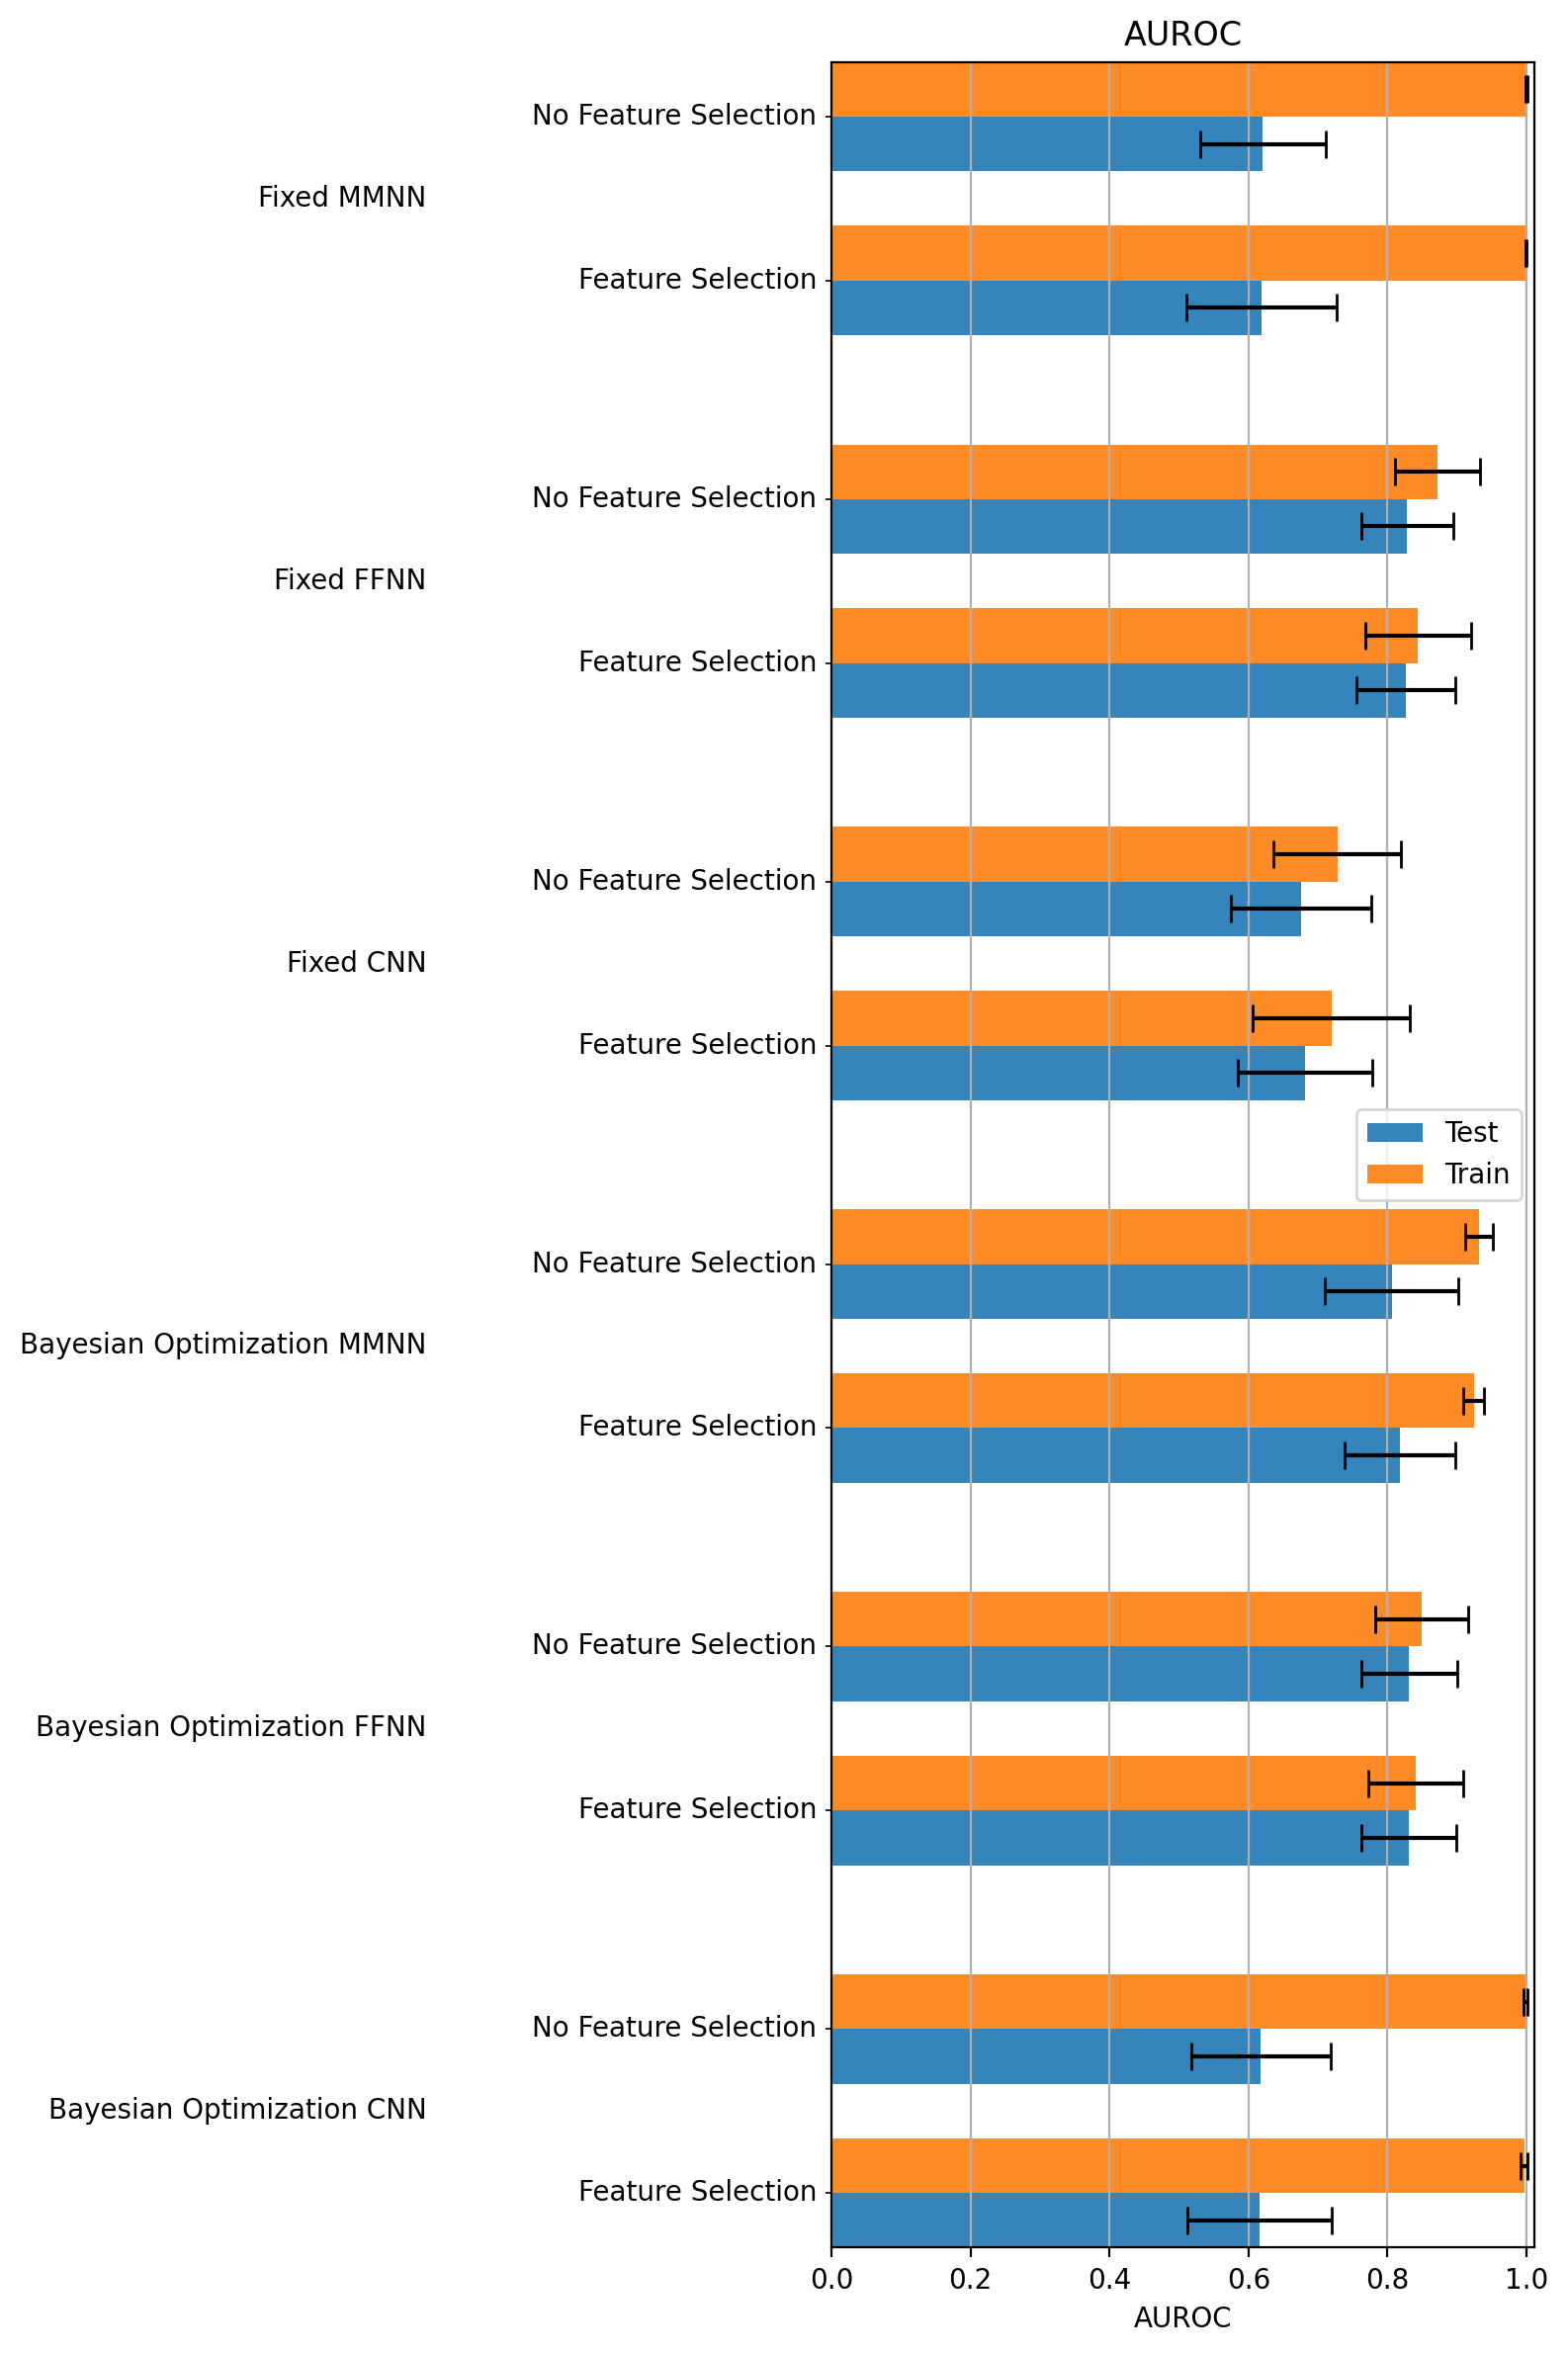

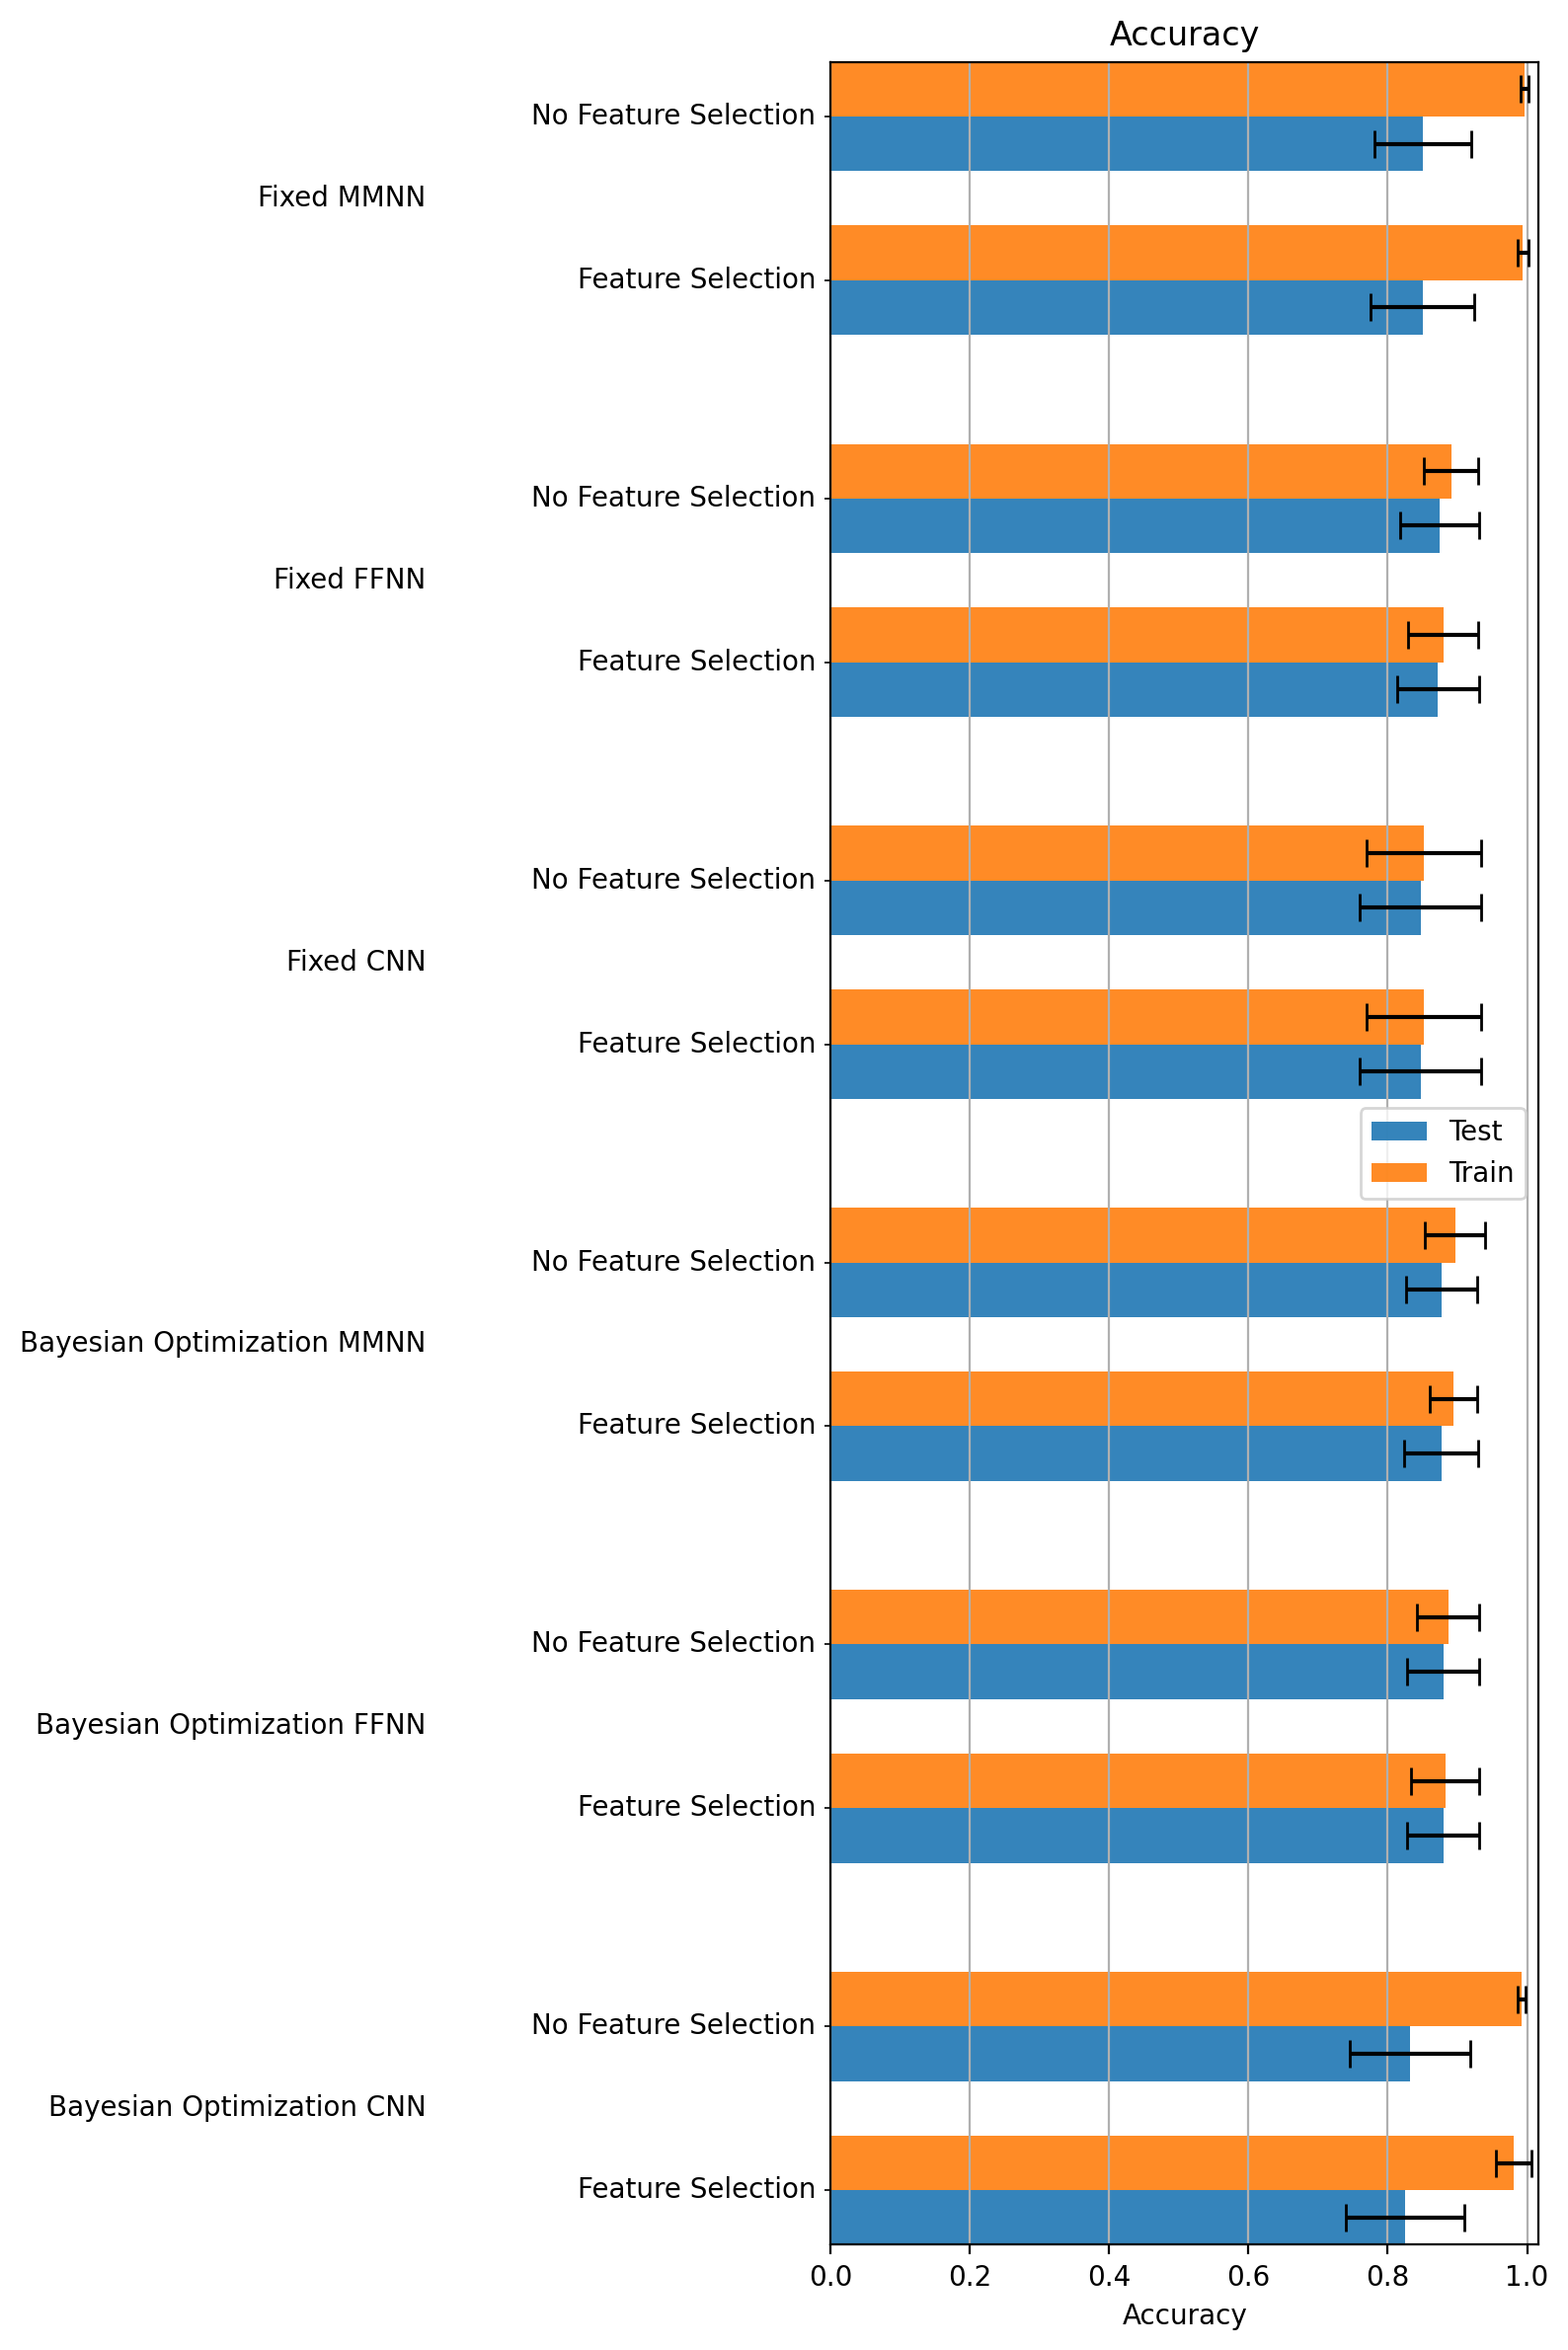

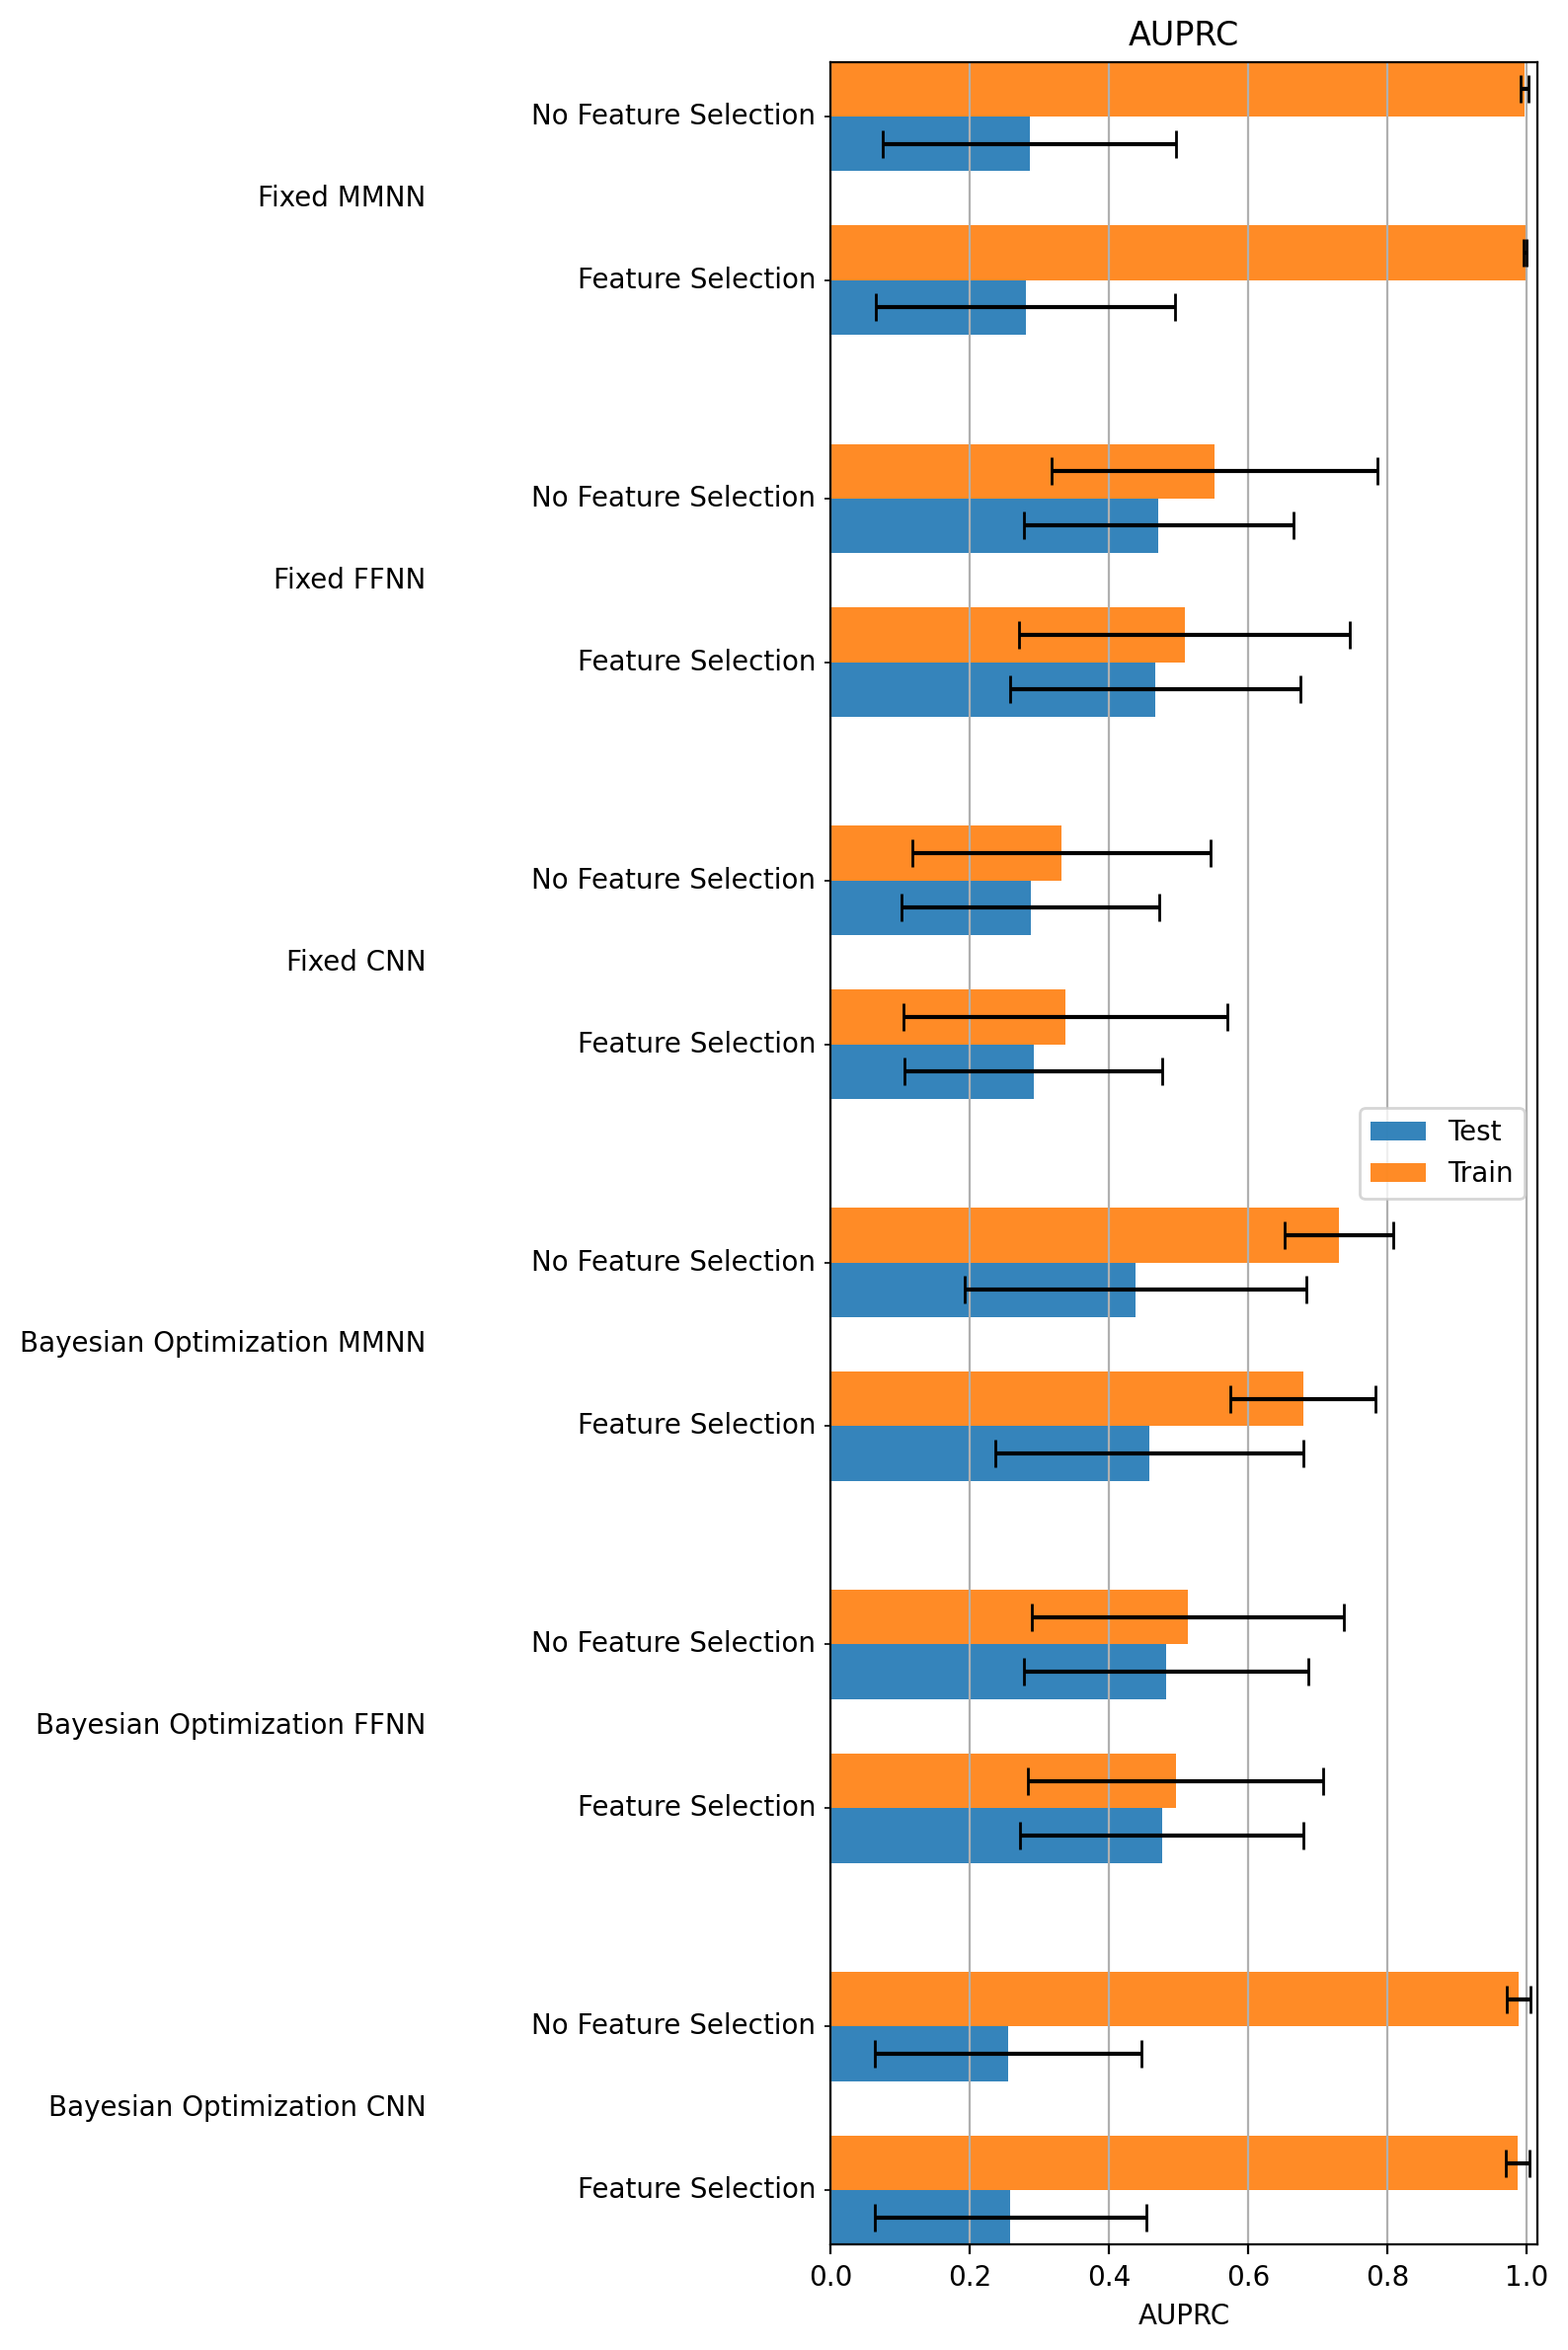

In [66]:
result(all_performance, "Enhancer")

In [67]:
from scipy.stats import wilcoxon

for model in all_performance.model_name.unique():
    model_performance = all_performance[
        (all_performance.model_name == model) &
        (all_performance.run_type == "test")]
    performance_with_feature_selection = model_performance[
        all_performance.use_feature_selection == "Feature Selection"
    ]
    performance_without_feature_selection = model_performance[
        all_performance.use_feature_selection == "No Feature Selection"
    ]

    for metric in ("AUPRC", "AUROC", "accuracy"):
        print(
            model,
            metric,
            wilcoxon(performance_with_feature_selection[metric], performance_without_feature_selection[metric])
        )

Bayesian_Optimization_FFNN AUPRC WilcoxonResult(statistic=0.0, pvalue=0.125)
Bayesian_Optimization_FFNN AUROC WilcoxonResult(statistic=3.0, pvalue=0.625)
Bayesian_Optimization_FFNN accuracy WilcoxonResult(statistic=4.5, pvalue=0.875)
Bayesian_Optimization_CNN AUPRC WilcoxonResult(statistic=3.0, pvalue=0.625)
Bayesian_Optimization_CNN AUROC WilcoxonResult(statistic=3.0, pvalue=0.625)
Bayesian_Optimization_CNN accuracy WilcoxonResult(statistic=2.0, pvalue=0.375)
Fixed_FFNN AUPRC WilcoxonResult(statistic=4.0, pvalue=0.875)
Fixed_FFNN AUROC WilcoxonResult(statistic=4.0, pvalue=0.875)
Fixed_FFNN accuracy WilcoxonResult(statistic=3.0, pvalue=0.625)
Fixed_CNN AUPRC WilcoxonResult(statistic=2.0, pvalue=0.375)
Fixed_CNN AUROC WilcoxonResult(statistic=3.0, pvalue=0.625)
Fixed_CNN accuracy WilcoxonResult(statistic=1.0, pvalue=0.6547208460185769)
Fixed_MMNN AUPRC WilcoxonResult(statistic=3.0, pvalue=0.625)
Fixed_MMNN AUROC WilcoxonResult(statistic=4.0, pvalue=0.875)
Fixed_MMNN accuracy WilcoxonRes